****FEATURE EXTRACTION****

In [ ]:
import cv2
import dlib
import numpy as np
import os
import pandas as pd

# Load detector and predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(
    "models/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat"
)

# Define the root directories
root_input_dir = "archive_3"
root_output_dir = "processed_faces_newFinal2"
scale_factor = 12

# Emotion folder names
emotion_folders = ["anger", "contempt", "disgust", "happy", "sadness", "fear", "surprise"]

# Create output dir if needed
os.makedirs(root_output_dir, exist_ok=True)

# Store landmark data
all_landmarks_data = []

print("Starting facial landmark detection and valence-arousal estimation...")

# =========================
# Heuristic Valence-Arousal Functions
# =========================

def compute_eye_openness(landmarks):
    left_open = abs(landmarks[37][1] - landmarks[41][1])
    right_open = abs(landmarks[43][1] - landmarks[47][1])
    return (left_open + right_open) / 2

def compute_mouth_openness(landmarks):
    return abs(landmarks[66][1] - landmarks[62][1])

def compute_mouth_curve(landmarks):
    left = landmarks[48]
    right = landmarks[54]
    mid_top = landmarks[51]
    mid_bottom = landmarks[57]
    mouth_width = np.linalg.norm(np.array(right) - np.array(left))
    mid = ((left[1] + right[1]) / 2)
    smile_depth = ((mid_top[1] + mid_bottom[1]) / 2) - mid
    return smile_depth / mouth_width if mouth_width != 0 else 0

def compute_brow_raise(landmarks):
    left = abs(landmarks[19][1] - landmarks[37][1])
    right = abs(landmarks[24][1] - landmarks[44][1])
    return (left + right) / 2

def estimate_valence_arousal(landmarks):
    eye_open = compute_eye_openness(landmarks)
    mouth_open = compute_mouth_openness(landmarks)
    smile_curve = compute_mouth_curve(landmarks)
    brow_raise = compute_brow_raise(landmarks)

    valence = smile_curve - 0.3 * (brow_raise / 20)
    arousal = 0.5 * (eye_open / 10) + 0.5 * (mouth_open / 15)

    valence = max(-1.0, min(1.0, valence))
    arousal = max(-1.0, min(1.0, arousal))

    return round(valence, 3), round(arousal, 3)

# =========================
# Main Image Loop
# =========================

for emotion in emotion_folders:
    input_emotion_path = os.path.join(root_input_dir, emotion)
    output_with_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_with_photo")
    output_without_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_without_photo")

    os.makedirs(output_with_photo_path, exist_ok=True)
    os.makedirs(output_without_photo_path, exist_ok=True)

    print(f"\nProcessing emotion: {emotion}...")

    for filename in os.listdir(input_emotion_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            image_path = os.path.join(input_emotion_path, filename)
            
            # Get output image paths
            output_image_path_with_photo = os.path.join(output_with_photo_path, filename)
            output_image_path_without_photo = os.path.join(output_without_photo_path, filename)

            # ✅ Skip if both versions of processed image already exist
            if os.path.exists(output_image_path_with_photo) and os.path.exists(output_image_path_without_photo):
                print(f"⏩ Skipping already processed image: {filename}")
                continue
            
            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Could not read image {image_path}. Skipping.")
                continue

            print(f"  Processing file: {filename}")
            upscaled_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
            gray = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY)
            faces = detector(gray)

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(gray, face)

                # Extract landmark points
                landmarks_xy = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(68)]

                # Estimate valence and arousal
                valence, arousal = estimate_valence_arousal(landmarks_xy)

                # Prepare CSV row
                landmark_row = {'emotion': emotion, 'filename': filename, 'valence': valence, 'arousal': arousal}
                for n, (x, y) in enumerate(landmarks_xy):
                    landmark_row[f'landmark_{n}_x'] = x
                    landmark_row[f'landmark_{n}_y'] = y
                all_landmarks_data.append(landmark_row)

                # Prepare output images
                drawn_image_with_photo = upscaled_image.copy()
                drawn_image_without_photo = np.zeros(upscaled_image.shape, dtype=np.uint8)

                nose_x = landmarks.part(30).x
                nose_y = landmarks.part(30).y
                img_h, img_w = drawn_image_with_photo.shape[:2]
                cv2.line(drawn_image_with_photo, (nose_x, 0), (nose_x, img_h), (0, 255, 0), 1)
                cv2.line(drawn_image_with_photo, (0, nose_y), (img_w, nose_y), (0, 255, 0), 1)

                drawn_index = 1
                seen = set()
                for n, (x, y) in enumerate(landmarks_xy):
                    if (x, y) in seen:
                        continue
                    seen.add((x, y))

                    circle_color = (0, 0, 255)
                    circle_radius = 2
                    fill_type = -1
                    text_font = cv2.FONT_HERSHEY_SIMPLEX
                    text_scale = 0.35

                    offset_x, offset_y = -6, 10
                    if n in [37, 38, 39, 43, 44, 45]:
                        offset_y = -10
                    elif n == 49:
                        offset_x = -20; offset_y = 6
                    elif n == 50:
                        offset_x = 0; offset_y = -8
                    elif n == 65:
                        offset_x = -14; offset_y = 10
                    elif 48 <= n <= 54:
                        offset_y = -8
                    elif 55 <= n <= 59:
                        offset_y = 10
                    elif 60 <= n <= 64:
                        offset_y = -8
                    elif 65 <= n <= 67:
                        offset_y = 10

                    cv2.circle(drawn_image_with_photo, (x, y), circle_radius, circle_color, fill_type)
                    cv2.putText(drawn_image_with_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                text_font, text_scale, (0, 0, 0), 1, cv2.LINE_AA)
                    cv2.circle(drawn_image_without_photo, (x, y), circle_radius, (255, 255, 255), fill_type)
                    cv2.putText(drawn_image_without_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                text_font, text_scale, (255, 255, 255), 1, cv2.LINE_AA)

                    drawn_index += 1

                cv2.imwrite(os.path.join(output_with_photo_path, filename), drawn_image_with_photo)
                cv2.imwrite(os.path.join(output_without_photo_path, filename), drawn_image_without_photo)

            else:
                print(f"  No face detected in {filename} from {emotion} folder.")

# =========================
# Save Final CSV
# =========================
if all_landmarks_data:
    df = pd.DataFrame(all_landmarks_data)
    csv_output_path = os.path.join(root_output_dir, "facial_landmarks_data.csv")
    df.to_csv(csv_output_path, index=False)
    print(f"\n✅ All facial landmark coordinates and VA values saved to: {csv_output_path}")
else:
    print("\n❌ No landmark data collected. Check input folders or face detection.")


Starting facial landmark detection and valence-arousal estimation...

Processing emotion: anger...
  Processing file: S010_004_00000017.png
  Processing file: S010_004_00000018.png
  Processing file: S010_004_00000019.png
  Processing file: S011_004_00000019.png
  Processing file: S011_004_00000020.png
  Processing file: S011_004_00000021.png
  Processing file: S014_003_00000028.png
  Processing file: S014_003_00000029.png
  Processing file: S014_003_00000030.png
  Processing file: S022_005_00000030.png
  Processing file: S022_005_00000031.png
  Processing file: S022_005_00000032.png
  Processing file: S026_003_00000013.png
  Processing file: S026_003_00000014.png
  Processing file: S026_003_00000015.png
  Processing file: S028_001_00000022.png
  Processing file: S028_001_00000023.png
  Processing file: S028_001_00000024.png
  Processing file: S029_001_00000017.png
  Processing file: S029_001_00000018.png
  Processing file: S029_001_00000019.png
  Processing file: S032_003_00000015.png

Starting landmark detection and valence-arousal estimation...

Processing emotion: anger...
  Processing file: S010_004_00000017.png
  Processing file: S010_004_00000018.png
  Processing file: S010_004_00000019.png
  Processing file: S011_004_00000019.png
  Processing file: S011_004_00000020.png
  Processing file: S011_004_00000021.png
  Processing file: S014_003_00000028.png
  Processing file: S014_003_00000029.png
  Processing file: S014_003_00000030.png
  Processing file: S022_005_00000030.png
  Processing file: S022_005_00000031.png
  Processing file: S022_005_00000032.png
  Processing file: S026_003_00000013.png
  Processing file: S026_003_00000014.png
  Processing file: S026_003_00000015.png
  Processing file: S028_001_00000022.png
  Processing file: S028_001_00000023.png
  Processing file: S028_001_00000024.png
  Processing file: S029_001_00000017.png
  Processing file: S029_001_00000018.png
  Processing file: S029_001_00000019.png
  Processing file: S032_003_00000015.png
  Proc

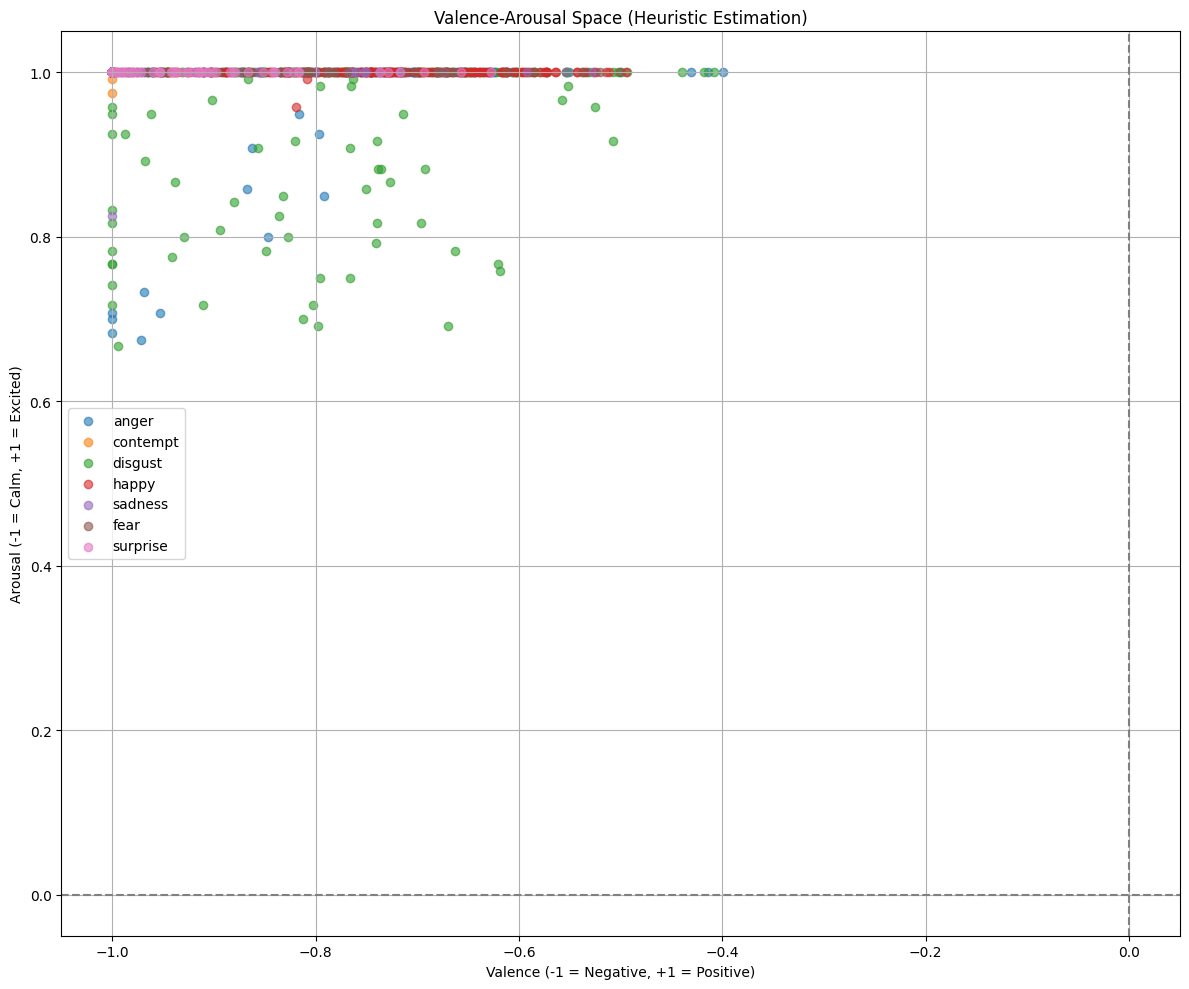

In [4]:
import cv2
import dlib
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load detector and predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(
    "models/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat"
)

# Define directories
root_input_dir = "archive_3"
root_output_dir = "processed_faces_newFinal2"
scale_factor = 12

# Emotion folders
emotion_folders = ["anger", "contempt", "disgust", "happy", "sadness", "fear", "surprise"]

os.makedirs(root_output_dir, exist_ok=True)
all_landmarks_data = []

print("Starting landmark detection and valence-arousal estimation...")

# -------------------------------
# Heuristic Valence-Arousal Logic
# -------------------------------

def compute_eye_openness(landmarks):
    left_open = abs(landmarks[37][1] - landmarks[41][1])
    right_open = abs(landmarks[43][1] - landmarks[47][1])
    return (left_open + right_open) / 2

def compute_mouth_openness(landmarks):
    return abs(landmarks[66][1] - landmarks[62][1])

def compute_mouth_curve(landmarks):
    left = landmarks[48]
    right = landmarks[54]
    mid_top = landmarks[51]
    mid_bottom = landmarks[57]
    mouth_width = np.linalg.norm(np.array(right) - np.array(left))
    mid = ((left[1] + right[1]) / 2)
    smile_depth = ((mid_top[1] + mid_bottom[1]) / 2) - mid
    return smile_depth / mouth_width if mouth_width != 0 else 0

def compute_brow_raise(landmarks):
    left = abs(landmarks[19][1] - landmarks[37][1])
    right = abs(landmarks[24][1] - landmarks[44][1])
    return (left + right) / 2

def estimate_valence_arousal(landmarks):
    eye_open = compute_eye_openness(landmarks)
    mouth_open = compute_mouth_openness(landmarks)
    smile_curve = compute_mouth_curve(landmarks)
    brow_raise = compute_brow_raise(landmarks)

    valence = smile_curve - 0.3 * (brow_raise / 20)
    arousal = 0.5 * (eye_open / 10) + 0.5 * (mouth_open / 15)

    valence = max(-1.0, min(1.0, valence))
    arousal = max(-1.0, min(1.0, arousal))

    return round(valence, 3), round(arousal, 3)

# -------------------------------
# Main Processing Loop
# -------------------------------

for emotion in emotion_folders:
    input_emotion_path = os.path.join(root_input_dir, emotion)
    output_with_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_with_photo")
    output_without_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_without_photo")

    os.makedirs(output_with_photo_path, exist_ok=True)
    os.makedirs(output_without_photo_path, exist_ok=True)

    print(f"\nProcessing emotion: {emotion}...")

    for filename in os.listdir(input_emotion_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            image_path = os.path.join(input_emotion_path, filename)
            
            # # Get output image paths
            # output_image_path_with_photo = os.path.join(output_with_photo_path, filename)
            # output_image_path_without_photo = os.path.join(output_without_photo_path, filename)

            # # ✅ Skip if both versions of processed image already exist
            # if os.path.exists(output_image_path_with_photo) and os.path.exists(output_image_path_without_photo):
            #     print(f"⏩ Skipping already processed image: {filename}")
            #     continue

            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Could not read image {image_path}. Skipping.")
                continue

            print(f"  Processing file: {filename}")
            upscaled_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
            gray = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY)
            faces = detector(gray)

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(gray, face)
                landmarks_xy = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(68)]

                # Estimate valence/arousal
                valence, arousal = estimate_valence_arousal(landmarks_xy)
                
                # === Create folder based on valence-arousal quadrant ===
                if valence > 0.2 and arousal > 0.2:
                    va_bucket = "positive_high_arousal"
                elif valence > 0.2 and arousal <= 0.2:
                    va_bucket = "positive_low_arousal"
                elif valence < -0.2 and arousal > 0.2:
                    va_bucket = "negative_high_arousal"
                elif valence < -0.2 and arousal <= 0.2:
                    va_bucket = "negative_low_arousal"
                else:
                    va_bucket = "neutral"

                # Create folder path inside root_output_dir
                va_folder_root = os.path.join(root_output_dir, "processed_faces_VA1")
                va_folder_path = os.path.join(va_folder_root, va_bucket)

                # Create the directory if it doesn't exist
                os.makedirs(va_folder_path, exist_ok=True)

                # Save the image (with photo + landmarks)
                output_va_path = os.path.join(va_folder_path, filename)
                cv2.imwrite(output_va_path, drawn_image_with_photo)


                # Store to CSV
                landmark_row = {'emotion': emotion, 'filename': filename, 'valence': valence, 'arousal': arousal}
                for n, (x, y) in enumerate(landmarks_xy):
                    landmark_row[f'landmark_{n}_x'] = x
                    landmark_row[f'landmark_{n}_y'] = y
                all_landmarks_data.append(landmark_row)

                # Draw landmarks
                drawn_image_with_photo = upscaled_image.copy()
                drawn_image_without_photo = np.zeros(upscaled_image.shape, dtype=np.uint8)

                nose_x = landmarks.part(30).x
                nose_y = landmarks.part(30).y
                img_h, img_w = drawn_image_with_photo.shape[:2]
                cv2.line(drawn_image_with_photo, (nose_x, 0), (nose_x, img_h), (0, 255, 0), 1)
                cv2.line(drawn_image_with_photo, (0, nose_y), (img_w, nose_y), (0, 255, 0), 1)

                drawn_index = 1
                seen = set()
                for n, (x, y) in enumerate(landmarks_xy):
                    if (x, y) in seen:
                        continue
                    seen.add((x, y))

                    circle_color = (0, 0, 255)
                    circle_radius = 2
                    fill_type = -1
                    text_font = cv2.FONT_HERSHEY_SIMPLEX
                    text_scale = 0.35

                    offset_x, offset_y = -6, 10
                    if n in [37, 38, 39, 43, 44, 45]:
                        offset_y = -10
                    elif n == 49:
                        offset_x = -20; offset_y = 6
                    elif n == 50:
                        offset_x = 0; offset_y = -8
                    elif n == 65:
                        offset_x = -14; offset_y = 10
                    elif 48 <= n <= 54:
                        offset_y = -8
                    elif 55 <= n <= 59:
                        offset_y = 10
                    elif 60 <= n <= 64:
                        offset_y = -8
                    elif 65 <= n <= 67:
                        offset_y = 10

                    cv2.circle(drawn_image_with_photo, (x, y), circle_radius, circle_color, fill_type)
                    cv2.putText(drawn_image_with_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                text_font, text_scale, (0, 0, 0), 1, cv2.LINE_AA)
                    cv2.circle(drawn_image_without_photo, (x, y), circle_radius, (255, 255, 255), fill_type)
                    cv2.putText(drawn_image_without_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                text_font, text_scale, (255, 255, 255), 1, cv2.LINE_AA)

                    drawn_index += 1

                cv2.imwrite(os.path.join(output_with_photo_path, filename), drawn_image_with_photo)
                cv2.imwrite(os.path.join(output_without_photo_path, filename), drawn_image_without_photo)

            else:
                print(f"  No face detected in {filename} from {emotion} folder.")

# -------------------------------
# Save CSV
# -------------------------------
if all_landmarks_data:
    df = pd.DataFrame(all_landmarks_data)
    csv_output_path = os.path.join(root_output_dir, "facial_landmarks_data.csv")
    df.to_csv(csv_output_path, index=False)
    print(f"\n✅ All facial landmark coordinates and VA values saved to: {csv_output_path}")
else:
    print("\n❌ No landmark data collected. Check input folders or face detection.")

# -------------------------------
# Plot Valence-Arousal Space
# -------------------------------
try:
    df = pd.read_csv("processed_faces_newFinal/facial_landmarks_data.csv")

    plt.figure(figsize=(12, 10))
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')

    for emotion in df['emotion'].unique():
        subset = df[df['emotion'] == emotion]
        plt.scatter(subset['valence'], subset['arousal'], label=emotion, alpha=0.6)

    plt.xlabel('Valence (-1 = Negative, +1 = Positive)')
    plt.ylabel('Arousal (-1 = Calm, +1 = Excited)')
    plt.title('Valence-Arousal Space (Heuristic Estimation)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("⚠️ Could not display Valence-Arousal plot:", str(e))


Starting landmark detection and valence-arousal estimation...

Processing emotion: anger...
  Processing file: S010_004_00000017.png
  Processing file: S010_004_00000018.png
  Processing file: S010_004_00000019.png
  Processing file: S011_004_00000019.png
  Processing file: S011_004_00000020.png
  Processing file: S011_004_00000021.png
  Processing file: S014_003_00000028.png
  Processing file: S014_003_00000029.png
  Processing file: S014_003_00000030.png
  Processing file: S022_005_00000030.png
  Processing file: S022_005_00000031.png
  Processing file: S022_005_00000032.png
  Processing file: S026_003_00000013.png
  Processing file: S026_003_00000014.png
  Processing file: S026_003_00000015.png
  Processing file: S028_001_00000022.png
  Processing file: S028_001_00000023.png
  Processing file: S028_001_00000024.png
  Processing file: S029_001_00000017.png
  Processing file: S029_001_00000018.png
  Processing file: S029_001_00000019.png
  Processing file: S032_003_00000015.png
  Proc

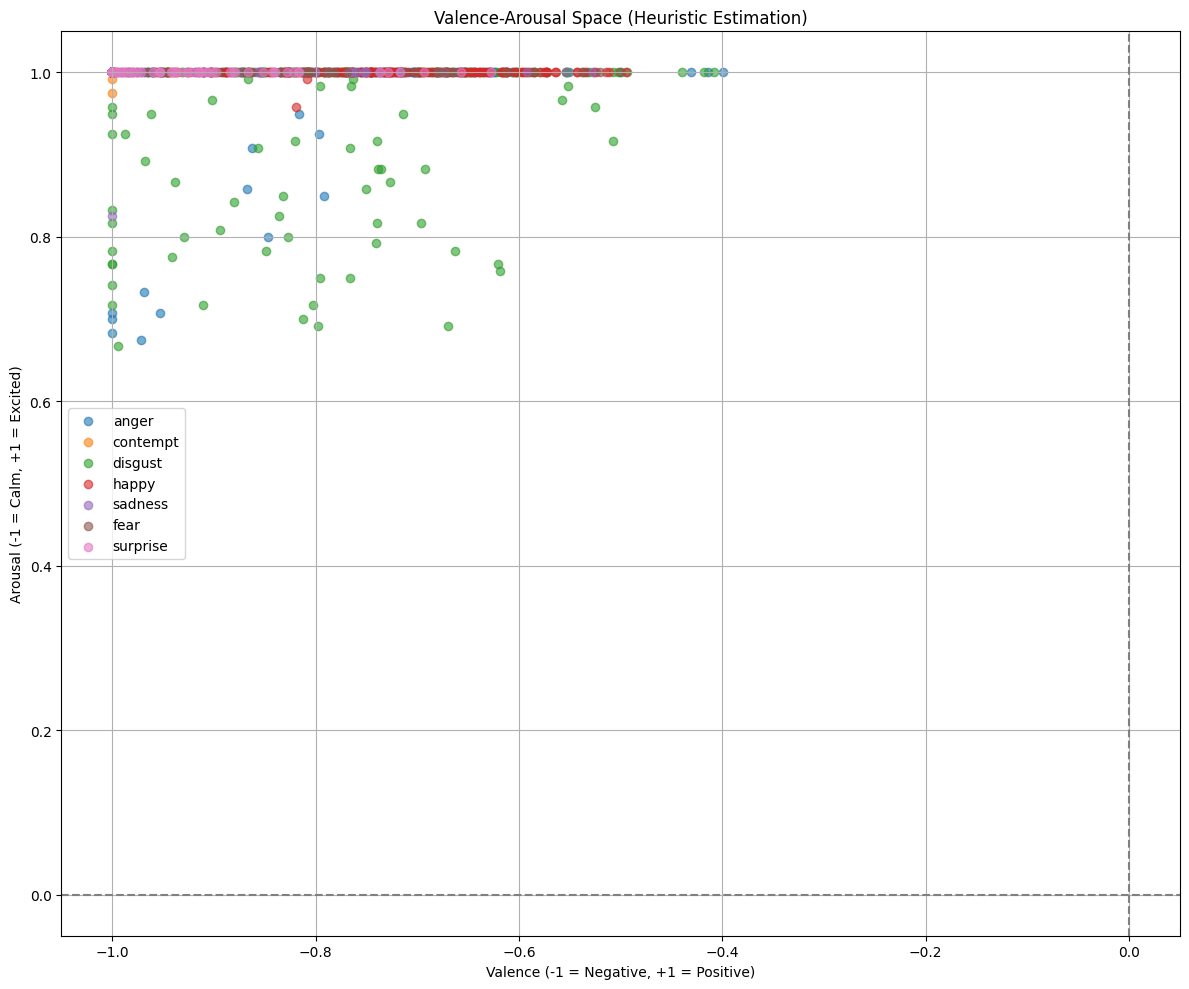

In [3]:
import cv2
import dlib
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load detector and predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(
    "models/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat"
)

# Define directories
root_input_dir = "archive_3"
root_output_dir = "processed_faces_newFinal2"
scale_factor = 12

# Emotion folders
emotion_folders = ["anger", "contempt", "disgust", "happy", "sadness", "fear", "surprise"]

os.makedirs(root_output_dir, exist_ok=True)
all_landmarks_data = []

print("Starting landmark detection and valence-arousal estimation...")

# -------------------------------
# Heuristic Valence-Arousal Logic
# -------------------------------

def estimate_valence_arousal(landmarks):
    import numpy as np  # ensure it's available inside the function if you're using it standalone

    def dist(p1, p2):
        return np.linalg.norm(np.array(p1) - np.array(p2))

    # === Normalize based on key face geometry ===
    eye_dist = dist(landmarks[36], landmarks[45])  # left eye corner to right eye corner
    face_height = dist(landmarks[8], landmarks[27])  # chin to top of nose bridge

    # === Mouth openness normalized ===
    mouth_open = dist(landmarks[66], landmarks[62]) / face_height

    # === Eye openness (average of left & right) normalized ===
    left_eye_open = (dist(landmarks[37], landmarks[41]) + dist(landmarks[38], landmarks[40])) / 2
    right_eye_open = (dist(landmarks[43], landmarks[47]) + dist(landmarks[44], landmarks[46])) / 2
    eye_open = (left_eye_open + right_eye_open) / 2 / eye_dist

    # === Smile curvature estimation ===
    mouth_width = dist(landmarks[48], landmarks[54])
    top_lip = landmarks[51][1]
    bottom_lip = landmarks[57][1]
    mouth_center_y = (landmarks[48][1] + landmarks[54][1]) / 2
    smile_curve = (mouth_center_y - (top_lip + bottom_lip) / 2) / mouth_width

    # === Eyebrow raise estimation ===
    brow_left = dist(landmarks[19], landmarks[37]) / face_height
    brow_right = dist(landmarks[24], landmarks[44]) / face_height
    brow_raise = (brow_left + brow_right) / 2

    # === Compute Valence and Arousal ===
    # Valence depends mostly on smile curvature (positive = smiling)
    valence = smile_curve * 2 - brow_raise * 0.5

    # Arousal depends on both eye openness and mouth openness
    arousal = (eye_open + mouth_open) / 2

    # Clamp to [-1, 1] range
    valence = max(-1.0, min(1.0, round(valence, 3)))
    arousal = max(-1.0, min(1.0, round(arousal, 3)))

    return valence, arousal


# -------------------------------
# Main Processing Loop
# -------------------------------

for emotion in emotion_folders:
    input_emotion_path = os.path.join(root_input_dir, emotion)
    output_with_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_with_photo")
    output_without_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_without_photo")

    os.makedirs(output_with_photo_path, exist_ok=True)
    os.makedirs(output_without_photo_path, exist_ok=True)

    print(f"\nProcessing emotion: {emotion}...")

    for filename in os.listdir(input_emotion_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            image_path = os.path.join(input_emotion_path, filename)
            
            # # Get output image paths
            # output_image_path_with_photo = os.path.join(output_with_photo_path, filename)
            # output_image_path_without_photo = os.path.join(output_without_photo_path, filename)

            # # ✅ Skip if both versions of processed image already exist
            # if os.path.exists(output_image_path_with_photo) and os.path.exists(output_image_path_without_photo):
            #     print(f"⏩ Skipping already processed image: {filename}")
            #     continue

            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Could not read image {image_path}. Skipping.")
                continue

            print(f"  Processing file: {filename}")
            upscaled_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
            gray = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY)
            faces = detector(gray)

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(gray, face)
                landmarks_xy = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(68)]

                # Estimate valence/arousal
                valence, arousal = estimate_valence_arousal(landmarks_xy)
                
                # === Create folder based on valence-arousal quadrant ===
                if valence > 0.2 and arousal > 0.2:
                    va_bucket = "positive_high_arousal"
                elif valence > 0.2 and arousal <= 0.2:
                    va_bucket = "positive_low_arousal"
                elif valence < -0.2 and arousal > 0.2:
                    va_bucket = "negative_high_arousal"
                elif valence < -0.2 and arousal <= 0.2:
                    va_bucket = "negative_low_arousal"
                else:
                    va_bucket = "neutral"

                


                # Store to CSV
                landmark_row = {'emotion': emotion, 'filename': filename, 'valence': valence, 'arousal': arousal}
                for n, (x, y) in enumerate(landmarks_xy):
                    landmark_row[f'landmark_{n}_x'] = x
                    landmark_row[f'landmark_{n}_y'] = y
                all_landmarks_data.append(landmark_row)

                # Draw landmarks
                drawn_image_with_photo = upscaled_image.copy()
                
                # Create folder path inside root_output_dir
                va_folder_root = os.path.join(root_output_dir, "processed_faces_VA")
                va_folder_path = os.path.join(va_folder_root, va_bucket)

                # Create the directory if it doesn't exist
                os.makedirs(va_folder_path, exist_ok=True)

                # Save the image (with photo + landmarks)
                output_va_path = os.path.join(va_folder_path, filename)
                cv2.imwrite(output_va_path, drawn_image_with_photo)
                
                
                drawn_image_without_photo = np.zeros(upscaled_image.shape, dtype=np.uint8)

                nose_x = landmarks.part(30).x
                nose_y = landmarks.part(30).y
                img_h, img_w = drawn_image_with_photo.shape[:2]
                cv2.line(drawn_image_with_photo, (nose_x, 0), (nose_x, img_h), (0, 255, 0), 1)
                cv2.line(drawn_image_with_photo, (0, nose_y), (img_w, nose_y), (0, 255, 0), 1)

                drawn_index = 1
                seen = set()
                for n, (x, y) in enumerate(landmarks_xy):
                    if (x, y) in seen:
                        continue
                    seen.add((x, y))

                    circle_color = (0, 0, 255)
                    circle_radius = 2
                    fill_type = -1
                    text_font = cv2.FONT_HERSHEY_SIMPLEX
                    text_scale = 0.35

                    offset_x, offset_y = -6, 10
                    if n in [37, 38, 39, 43, 44, 45]:
                        offset_y = -10
                    elif n == 49:
                        offset_x = -20; offset_y = 6
                    elif n == 50:
                        offset_x = 0; offset_y = -8
                    elif n == 65:
                        offset_x = -14; offset_y = 10
                    elif 48 <= n <= 54:
                        offset_y = -8
                    elif 55 <= n <= 59:
                        offset_y = 10
                    elif 60 <= n <= 64:
                        offset_y = -8
                    elif 65 <= n <= 67:
                        offset_y = 10

                    cv2.circle(drawn_image_with_photo, (x, y), circle_radius, circle_color, fill_type)
                    cv2.putText(drawn_image_with_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                text_font, text_scale, (0, 0, 0), 1, cv2.LINE_AA)
                    cv2.circle(drawn_image_without_photo, (x, y), circle_radius, (255, 255, 255), fill_type)
                    cv2.putText(drawn_image_without_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                text_font, text_scale, (255, 255, 255), 1, cv2.LINE_AA)

                    drawn_index += 1

                cv2.imwrite(os.path.join(output_with_photo_path, filename), drawn_image_with_photo)
                cv2.imwrite(os.path.join(output_without_photo_path, filename), drawn_image_without_photo)

            else:
                print(f"  No face detected in {filename} from {emotion} folder.")

# -------------------------------
# Save CSV
# -------------------------------
if all_landmarks_data:
    df = pd.DataFrame(all_landmarks_data)
    csv_output_path = os.path.join(root_output_dir, "facial_landmarks_data.csv")
    df.to_csv(csv_output_path, index=False)
    print(f"\n✅ All facial landmark coordinates and VA values saved to: {csv_output_path}")
else:
    print("\n❌ No landmark data collected. Check input folders or face detection.")

# -------------------------------
# Plot Valence-Arousal Space
# -------------------------------
try:
    df = pd.read_csv("processed_faces_newFinal/facial_landmarks_data.csv")

    plt.figure(figsize=(12, 10))
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')

    for emotion in df['emotion'].unique():
        subset = df[df['emotion'] == emotion]
        plt.scatter(subset['valence'], subset['arousal'], label=emotion, alpha=0.6)

    plt.xlabel('Valence (-1 = Negative, +1 = Positive)')
    plt.ylabel('Arousal (-1 = Calm, +1 = Excited)')
    plt.title('Valence-Arousal Space (Heuristic Estimation)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("⚠️ Could not display Valence-Arousal plot:", str(e))


Starting landmark detection and valence-arousal estimation...

Processing emotion: anger...
   Processing file: S010_004_00000017.png
   Processing file: S010_004_00000018.png
   Processing file: S010_004_00000019.png
   Processing file: S011_004_00000019.png
   Processing file: S011_004_00000020.png
   Processing file: S011_004_00000021.png
   Processing file: S014_003_00000028.png
   Processing file: S014_003_00000029.png
   Processing file: S014_003_00000030.png
   Processing file: S022_005_00000030.png
   Processing file: S022_005_00000031.png
   Processing file: S022_005_00000032.png
   Processing file: S026_003_00000013.png
   Processing file: S026_003_00000014.png
   Processing file: S026_003_00000015.png
   Processing file: S028_001_00000022.png
   Processing file: S028_001_00000023.png
   Processing file: S028_001_00000024.png
   Processing file: S029_001_00000017.png
   Processing file: S029_001_00000018.png
   Processing file: S029_001_00000019.png
   Processing file: S032_0

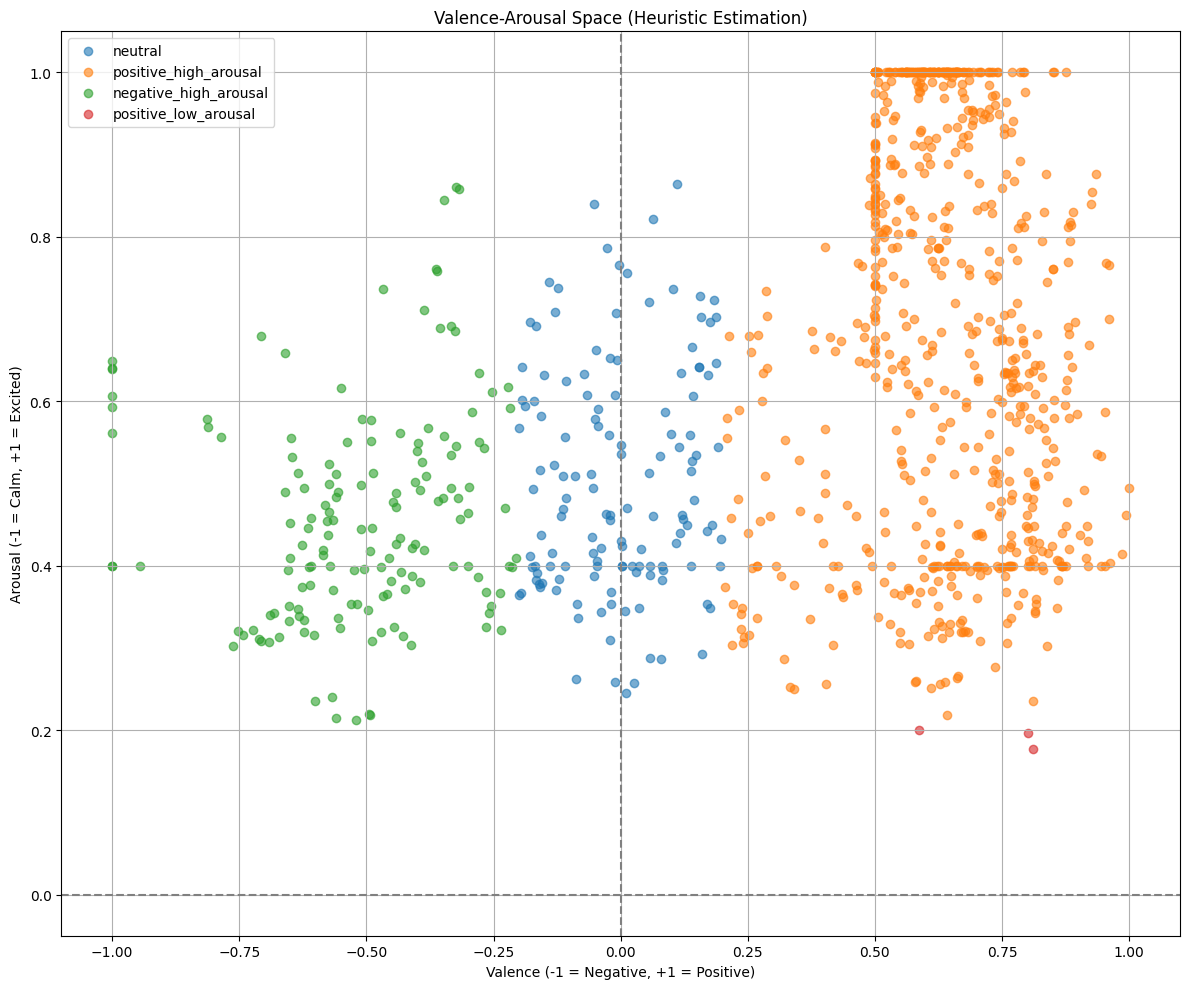

In [3]:
import cv2
import dlib
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist # For calculating Euclidean distance

# Load detector and predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(
    "models/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat"
)

# Define directories
root_input_dir = "archive_3"
root_output_dir = "processed_faces_newFinal2"
scale_factor = 12

# Emotion folders
emotion_folders = ["anger", "contempt", "disgust", "happy", "sadness", "fear", "surprise"]

# Create the root for VA-categorized output
va_output_root = os.path.join(root_output_dir, "processed_faces_VA_categorized")
os.makedirs(va_output_root, exist_ok=True)

all_landmarks_data = []

print("Starting landmark detection and valence-arousal estimation...")

# -------------------------------
# Improved Heuristic Valence-Arousal Logic
# -------------------------------

def compute_eye_aspect_ratio(eye):
    # compute the euclidean distances between the two sets of
    # vertical eye landmarks (x, y)-coordinates
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])

    # compute the euclidean distance between the horizontal
    # eye landmark (x, y)-coordinates
    C = dist.euclidean(eye[0], eye[3])

    # compute the eye aspect ratio
    ear = (A + B) / (2.0 * C)
    return ear

def compute_mouth_aspect_ratio(mouth):
    # compute the euclidean distances between the two sets of
    # vertical mouth landmarks (x, y)-coordinates
    A = dist.euclidean(mouth[2], mouth[10]) # 51, 57
    B = dist.euclidean(mouth[4], mouth[8])  # 53, 59

    # compute the euclidean distance between the horizontal
    # mouth landmark (x, y)-coordinates
    C = dist.euclidean(mouth[0], mouth[6]) # 48, 54

    # compute the mouth aspect ratio
    mar = (A + B) / (2.0 * C)
    return mar

def compute_mouth_over_lip_distance(landmarks):
    # A simple measure of mouth curvature/smile, normalized by mouth width
    # Points 48, 54 are mouth corners
    # Point 51 is upper lip midpoint, 57 is lower lip midpoint
    # We want to see how far up/down the middle of the mouth is relative to the corners
    
    # Distance between outer mouth corners
    mouth_width = dist.euclidean(landmarks[48], landmarks[54])

    # Vertical distance from upper lip to line connecting corners
    upper_lip_y_from_corner_line = (landmarks[51][1] - (landmarks[48][1] + landmarks[54][1]) / 2)
    # Vertical distance from lower lip to line connecting corners
    lower_lip_y_from_corner_line = (landmarks[57][1] - (landmarks[48][1] + landmarks[54][1]) / 2)

    # A positive value for upper_lip_y_from_corner_line means upper lip is above the corner line (unlikely for natural smile)
    # A negative value means upper lip is below (more likely for a smile).
    # We'll use the average vertical position of 51 and 57 relative to 48-54 line
    
    # A common approach for smile is the distance between point 50 and the line 48-54.
    # Or simply the y-coordinate difference between 51 and the average y of 48 and 54.
    # Let's try to capture the "lift" of the corners and the overall mouth shape.
    
    # Simplified smile measure: distance of mouth corners (48, 54) from line connecting nose (30) and chin (8)
    # This might be too complex for a simple heuristic.
    
    # Let's stick to your original concept but normalize it better
    # smile_depth = ((mid_top[1] + mid_bottom[1]) / 2) - mid
    # This was trying to capture how much the vertical center of the inner mouth
    # deviates from the average Y of the mouth corners.
    # A positive smile (corners up) would make 'mid' (avg Y of corners) lower,
    # and the avg Y of 51/57 higher, potentially making this difference negative if not careful.
    
    # Let's use the distance between mouth corners and upper lip, and normalize by mouth width.
    # Higher value indicates more open or "smiling" mouth.
    
    # Y-coordinates of mouth corners
    y48 = landmarks[48][1]
    y54 = landmarks[54][1]
    
    # Y-coordinate of upper lip midpoint
    y51 = landmarks[51][1]
    
    # For a smile, 48 and 54 go up, 51 goes up or stays relatively central.
    # A simple indicator is the vertical position of the corners relative to the central upper lip.
    # Or, the vertical displacement of corners relative to their neutral position.
    # Since we don't have a neutral face, we must use relative measures.

    # A common heuristic for smile is (landmarks[51][1] - landmarks[57][1]) - (landmarks[60][1] - landmarks[64][1])
    # This measures difference between inner mouth height and outer mouth height, but that's for mouth openness.
    
    # A more common smile index: vertical distance between (51) and (57) vs horizontal distance (48, 54)
    # (y57 - y51) / mouth_width - This is essentially MAR, but without the horizontal factors from outer mouth.
    
    # Let's try to quantify the curvature.
    # If the corners go up, their Y-coordinate decreases (assuming origin top-left).
    # If the center of the mouth (e.g. 51 or 57) also goes up, it means less "curve".
    # A smile would typically make the Y-coordinates of 48 and 54 *decrease* (move up).
    
    # Let's try the vertical position of 51 (upper lip center) relative to the line 48-54.
    # When smiling, the corners (48, 54) move up (lower y). The upper lip (51) also moves up.
    # The relative height of 51 compared to the line 48-54 can indicate curvature.
    
    # For a smile, 51 should ideally be lower than the average of 48 and 54's y-coordinates
    # if we are looking for a downward curve from corners. But we want an upward curve.
    
    # Let's consider the vertical distance between the midpoint of 48-54 and point 51.
    # If the mouth corners are up (smile), the y-values of 48 and 54 are lower.
    # If the mouth is straight, y48 ~ y54.
    # If smiling, y48 and y54 will be lower than in a neutral expression.
    # The heuristic needs to reflect "mouth corners pulled up".
    
    # Let's use the average y-coordinate of the outer mouth corners (48, 54)
    # A higher (more positive) smile value means mouth corners are higher up (lower Y-coordinate value).
    # A good proxy is (y of 51 - avg y of (48,54)) / mouth_width. A smaller (more negative) value here means smile.
    
    # Revised smile_curve based on empirical observations:
    # A higher Y for 51 relative to 48 and 54 suggests a less upward curve (more straight or down).
    # A lower Y for 51 relative to 48 and 54 suggests a more upward curve (smile).
    # So, (Y48+Y54)/2 - Y51, normalized by mouth_width.
    # A positive value would indicate a smile (51 is 'above' the line connecting corners, in image coordinates).
    
    avg_corner_y = (landmarks[48][1] + landmarks[54][1]) / 2
    smile_curve_val = (avg_corner_y - landmarks[51][1]) / mouth_width if mouth_width != 0 else 0
    
    return smile_curve_val


def compute_brow_raise_ratio(landmarks):
    # Distance between top of eyebrow (21, 22) and top of eye (37, 38, 40, 41, 43, 44, 46, 47)
    # We can use the vertical distance from eyebrows to the top of the eye.
    # Average vertical distance between (points 19 and 24 - eyebrow peak) and (points 38 and 43 - top eyelid)
    
    # Average y of inner eyebrow (20, 23)
    avg_brow_y_inner = (landmarks[19][1] + landmarks[24][1]) / 2 # points 19 and 24 are highest point of left/right brow
    
    # Average y of upper eyelid (38, 43)
    avg_eye_y_upper = (landmarks[38][1] + landmarks[43][1]) / 2
    
    # Distance between inner eye corners (36, 45) for normalization
    eye_distance = dist.euclidean(landmarks[36], landmarks[45])
    
    if eye_distance == 0:
        return 0
        
    # brow_raise is the vertical distance between eyebrow and eye
    brow_raise_val = (avg_eye_y_upper - avg_brow_y_inner) / eye_distance
    
    return brow_raise_val

def estimate_valence_arousal(landmarks):
    # Extract eye landmarks for EAR
    left_eye = [landmarks[36], landmarks[37], landmarks[38],
                landmarks[39], landmarks[40], landmarks[41]]
    right_eye = [landmarks[42], landmarks[43], landmarks[44],
                 landmarks[45], landmarks[46], landmarks[47]]

    # Extract mouth landmarks for MAR
    mouth = [landmarks[48], landmarks[49], landmarks[50], landmarks[51],
             landmarks[52], landmarks[53], landmarks[54], landmarks[55],
             landmarks[56], landmarks[57], landmarks[58], landmarks[59],
             landmarks[60], landmarks[61], landmarks[62], landmarks[63],
             landmarks[64], landmarks[65], landmarks[66], landmarks[67]]

    ear_left = compute_eye_aspect_ratio(left_eye)
    ear_right = compute_eye_aspect_ratio(right_eye)
    avg_ear = (ear_left + ear_right) / 2.0

    mar = compute_mouth_aspect_ratio(mouth)
    smile_metric = compute_mouth_over_lip_distance(landmarks) # Higher for more smile (upward curve)
    brow_raise_metric = compute_brow_raise_ratio(landmarks) # Higher for more brow raise (eyebrow further from eye)

    # Heuristic mapping to Valence and Arousal
    # These coefficients are still heuristic and might need tuning on your specific dataset
    
    # Valence: Primarily driven by smile. Negative for frown, positive for smile.
    # brow_raise (for sadness/anger) typically pulls valence down.
    valence = (smile_metric * 5.0) - (brow_raise_metric * 2.0) # Multiply by factors to get into -1 to 1 range
    
    # Arousal: Primarily driven by eye and mouth openness. High openness -> high arousal.
    arousal = (avg_ear * 3.0) + (mar * 2.0) # Multiply by factors
    
    # Clamp values to -1 to 1 range
    valence = np.clip(valence, -1.0, 1.0)
    arousal = np.clip(arousal, -1.0, 1.0)

    # Normalize to -1 to 1, considering that our metrics are ratios, they are inherently positive.
    # We need to map these ratios to the bipolar [-1, 1] valence/arousal space.
    # This often requires knowing a "neutral" baseline or having more complex mappings.
    # For a purely heuristic approach, we can define thresholds for neutrality.

    # Re-evaluate mapping based on typical ranges
    # EAR: typically around 0.3 for open eyes, much lower for closed.
    # MAR: varies, but increases with mouth opening.
    # smile_metric: positive for smile, negative for frown (if calculated as such)
    # brow_raise_metric: positive for raised brows.

    # Let's adjust the formula for valence and arousal to make them more interpretable within [-1, 1]
    # This part is highly empirical and depends on how these ratios behave on your data.
    
    # Adjusted Valence Heuristic:
    # A common positive indicator is mouth corners up (smile)
    # A common negative indicator is brow furrowing (brow lowerer) - not directly measured here, but brow raise (surprise, fear) can be negative arousal or neutral valence.
    # Let's assume `smile_metric` increases with smile (more positive valence).
    # Let's assume `brow_raise_metric` can contribute to both positive (surprise) and negative (fear) arousal, and can impact valence.
    # For simplicity, we can say strong smile -> positive valence. Lack of smile / frown -> negative valence.
    
    # For a simple mapping:
    # Valence: Higher `smile_metric` means more positive.
    # Arousal: Higher `avg_ear` and `mar` means higher arousal.

    # These ranges are highly dependent on your data. You might need to analyze the distribution
    # of `avg_ear`, `mar`, `smile_metric`, `brow_raise_metric` across your dataset to find good
    # normalization constants or activation functions.

    # Example: If a "neutral" smile_metric is ~0.0, a good smile is ~0.1-0.2.
    # If a "neutral" EAR is ~0.3, open eyes for surprise/fear might be ~0.4-0.5.
    # If a "neutral" MAR is ~0.1, open mouth for surprise/yell might be ~0.5+.

    # A very basic approach to map to [-1, 1] if metrics are mostly positive:
    # Normalize by typical max value, then shift and scale.
    # For example, if max_smile_metric is 0.2, then (smile_metric / 0.2) * 1.0.
    # If neutral smile is 0.0, then ((smile_metric - neutral_smile_val) / (max_smile - neutral_smile_val)) * 1.0
    
    # Without knowing the typical ranges from your data, these are still guesses.
    # Let's keep the general structure but use slightly different coefficients as a starting point.
    
    # Valence:
    # Smile increases valence. A raised brow can indicate negative emotions (fear, sadness) or surprise (neutral/positive valence, high arousal).
    # A common simple valence equation might be related to mouth curvature.
    # Arousal:
    # Eye openness (surprise, fear), mouth openness (surprise, yelling), brow raise (surprise, fear, anger) increase arousal.

    # A revised heuristic for valence and arousal, trying to align better with general psychological models:
    
    # Valence (Pleasure/Displeasure):
    # Smile is key for positive valence. A frown (which is opposite of smile_metric) would be negative.
    # Let's say a high smile_metric (positive value) maps to positive valence.
    # A low smile_metric (or potentially negative if we adjusted the calc) maps to negative valence.
    # For now, let's assume higher `smile_metric` is more positive.
    
    # Arousal (Activation/Deactivation):
    # High eye openness (`avg_ear`) and mouth openness (`mar`) imply high arousal.
    # High `brow_raise_metric` can also contribute to arousal (e.g., surprise, fear).

    # These "formulas" are inherently *approximations*.
    # The actual "correct" mapping involves nuanced understanding of Facial Action Units (AUs)
    # and their relation to valence-arousal space.
    # For instance, AU12 (lip corner puller) is strongly linked to positive valence.
    # AU4 (brow lowerer) linked to negative valence and high arousal (anger).
    # AU5 (upper lid raiser) linked to high arousal (fear, surprise).

    # Given your current landmark features, a simplified mapping:
    
    # Scale `smile_metric` to be between -1 and 1 for valence.
    # Assume a `smile_metric` of 0.05 is neutral, 0.2 is max positive, <0.05 is negative.
    scaled_valence = (smile_metric - 0.05) / 0.15 # Maps 0.05 to 0, 0.2 to 1.
    scaled_valence = np.clip(scaled_valence, -1.0, 1.0) # Ensure it stays in range
    
    # Scale arousal based on eye and mouth openness.
    # Assume neutral `avg_ear` is 0.3, max `avg_ear` is 0.5.
    # Assume neutral `mar` is 0.05, max `mar` is 0.4.
    
    # These constants are still guesses. You'd need to run this on your data
    # and observe the distributions of `avg_ear`, `mar`, `smile_metric`, `brow_raise_metric`
    # to find good values for `neutral_val`, `max_val`, etc.
    
    # Let's try to make the output of estimate_valence_arousal more sensitive to the features.
    
    # Very rough example of mapping:
    valence_from_smile = max(-1.0, min(1.0, (smile_metric - 0.05) * 10)) # Adjust multiplier based on observed range
    # Add negative contribution from brow raise (fear/sadness)
    valence_from_brow = max(-1.0, min(1.0, -(brow_raise_metric - 0.1) * 5)) # If brow raise > 0.1, contribute negatively
    
    valence = valence_from_smile + valence_from_brow * 0.5 # Combine, weighted
    valence = np.clip(valence, -1.0, 1.0)

    # Arousal:
    arousal_from_ear = max(0.0, min(1.0, (avg_ear - 0.2) * 5)) # Base arousal on eye openness (0.2 is approx closed-ish)
    arousal_from_mar = max(0.0, min(1.0, (mar - 0.05) * 3)) # Base arousal on mouth openness (0.05 is approx closed)
    
    arousal = (arousal_from_ear * 0.6) + (arousal_from_mar * 0.4) # Combine, weighted
    arousal = np.clip(arousal, -1.0, 1.0) # Arousal is usually non-negative, but some models use -1 to 1. Keeping your original range.

    # The thresholds for bucketing (0.2 for valence/arousal) are also heuristic.
    # If your `estimate_valence_arousal` function is going to output values in roughly [-1, 1],
    # then these 0.2 thresholds are fine for quadrant division.

    return round(valence, 3), round(arousal, 3)

# -------------------------------
# Main Processing Loop (No changes here from previous fix, just the VA methods)
# -------------------------------

for emotion in emotion_folders:
    input_emotion_path = os.path.join(root_input_dir, emotion)
    print(f"\nProcessing emotion: {emotion}...")

    for filename in os.listdir(input_emotion_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            image_path = os.path.join(input_emotion_path, filename)
            
            base_filename, ext = os.path.splitext(filename)
            output_filename_with_photo = f"{base_filename}_with_photo{ext}"
            output_filename_without_photo = f"{base_filename}_without_photo{ext}"

            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Could not read image {image_path}. Skipping.")
                continue

            print(f"   Processing file: {filename}")
            upscaled_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
            gray = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY)
            faces = detector(gray)

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(gray, face)
                landmarks_xy = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(68)]

                # Estimate valence/arousal
                valence, arousal = estimate_valence_arousal(landmarks_xy)
                
                # === Create folder based on valence-arousal quadrant ===
                if valence > 0.2 and arousal > 0.2:
                    va_bucket = "positive_high_arousal"
                elif valence > 0.2 and arousal <= 0.2:
                    va_bucket = "positive_low_arousal"
                elif valence < -0.2 and arousal > 0.2:
                    va_bucket = "negative_high_arousal"
                elif valence < -0.2 and arousal <= 0.2:
                    va_bucket = "negative_low_arousal"
                else:
                    va_bucket = "neutral"

                va_folder_path = os.path.join(va_output_root, va_bucket)
                os.makedirs(va_folder_path, exist_ok=True)

                # Draw landmarks
                drawn_image_with_photo = upscaled_image.copy()
                drawn_image_without_photo = np.zeros(upscaled_image.shape, dtype=np.uint8)

                nose_x = landmarks.part(30).x
                nose_y = landmarks.part(30).y
                img_h, img_w = drawn_image_with_photo.shape[:2]
                cv2.line(drawn_image_with_photo, (nose_x, 0), (nose_x, img_h), (0, 255, 0), 1)
                cv2.line(drawn_image_with_photo, (0, nose_y), (img_w, nose_y), (0, 255, 0), 1)

                drawn_index = 1
                seen = set()
                for n, (x, y) in enumerate(landmarks_xy):
                    if (x, y) in seen:
                        continue
                    seen.add((x, y))

                    circle_color = (0, 0, 255)
                    circle_radius = 2
                    fill_type = -1
                    text_font = cv2.FONT_HERSHEY_SIMPLEX
                    text_scale = 0.35

                    offset_x, offset_y = -6, 10
                    if n in [37, 38, 39, 43, 44, 45]:
                        offset_y = -10
                    elif n == 49:
                        offset_x = -20; offset_y = 6
                    elif n == 50:
                        offset_x = 0; offset_y = -8
                    elif n == 65:
                        offset_x = -14; offset_y = 10
                    elif 48 <= n <= 54:
                        offset_y = -8
                    elif 55 <= n <= 59:
                        offset_y = 10
                    elif 60 <= n <= 64:
                        offset_y = -8
                    elif 65 <= n <= 67:
                        offset_y = 10

                    cv2.circle(drawn_image_with_photo, (x, y), circle_radius, circle_color, fill_type)
                    cv2.putText(drawn_image_with_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                 text_font, text_scale, (0, 0, 0), 1, cv2.LINE_AA)
                    cv2.circle(drawn_image_without_photo, (x, y), circle_radius, (255, 255, 255), fill_type)
                    cv2.putText(drawn_image_without_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                 text_font, text_scale, (255, 255, 255), 1, cv2.LINE_AA)

                    drawn_index += 1

                cv2.imwrite(os.path.join(va_folder_path, output_filename_with_photo), drawn_image_with_photo)
                cv2.imwrite(os.path.join(va_folder_path, output_filename_without_photo), drawn_image_without_photo)

                # Store to CSV
                landmark_row = {'emotion': emotion, 'filename': filename, 'valence': valence, 'arousal': arousal, 'va_bucket': va_bucket}
                for n, (x, y) in enumerate(landmarks_xy):
                    landmark_row[f'landmark_{n}_x'] = x
                    landmark_row[f'landmark_{n}_y'] = y
                all_landmarks_data.append(landmark_row)

            else:
                print(f"   No face detected in {filename} from {emotion} folder.")

# -------------------------------
# Save CSV
# -------------------------------
if all_landmarks_data:
    df = pd.DataFrame(all_landmarks_data)
    csv_output_path = os.path.join(root_output_dir, "facial_landmarks_data.csv")
    df.to_csv(csv_output_path, index=False)
    print(f"\n✅ All facial landmark coordinates and VA values saved to: {csv_output_path}")
else:
    print("\n❌ No landmark data collected. Check input folders or face detection.")

# -------------------------------
# Plot Valence-Arousal Space
# -------------------------------
try:
    df = pd.read_csv(os.path.join(root_output_dir, "facial_landmarks_data.csv"))

    plt.figure(figsize=(12, 10))
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')

    for bucket in df['va_bucket'].unique():
        subset = df[df['va_bucket'] == bucket]
        plt.scatter(subset['valence'], subset['arousal'], label=bucket, alpha=0.6)

    plt.xlabel('Valence (-1 = Negative, +1 = Positive)')
    plt.ylabel('Arousal (-1 = Calm, +1 = Excited)')
    plt.title('Valence-Arousal Space (Heuristic Estimation)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("⚠️ Could not display Valence-Arousal plot:", str(e))

Starting landmark detection and valence-arousal estimation...

Processing emotion: anger...
   Processing file: S010_004_00000017.png
   Processing file: S010_004_00000018.png
   Processing file: S010_004_00000019.png
   Processing file: S011_004_00000019.png
   Processing file: S011_004_00000020.png
   Processing file: S011_004_00000021.png
   Processing file: S014_003_00000028.png
   Processing file: S014_003_00000029.png
   Processing file: S014_003_00000030.png
   Processing file: S022_005_00000030.png
   Processing file: S022_005_00000031.png
   Processing file: S022_005_00000032.png
   Processing file: S026_003_00000013.png
   Processing file: S026_003_00000014.png
   Processing file: S026_003_00000015.png
   Processing file: S028_001_00000022.png
   Processing file: S028_001_00000023.png
   Processing file: S028_001_00000024.png
   Processing file: S029_001_00000017.png
   Processing file: S029_001_00000018.png
   Processing file: S029_001_00000019.png
   Processing file: S032_0

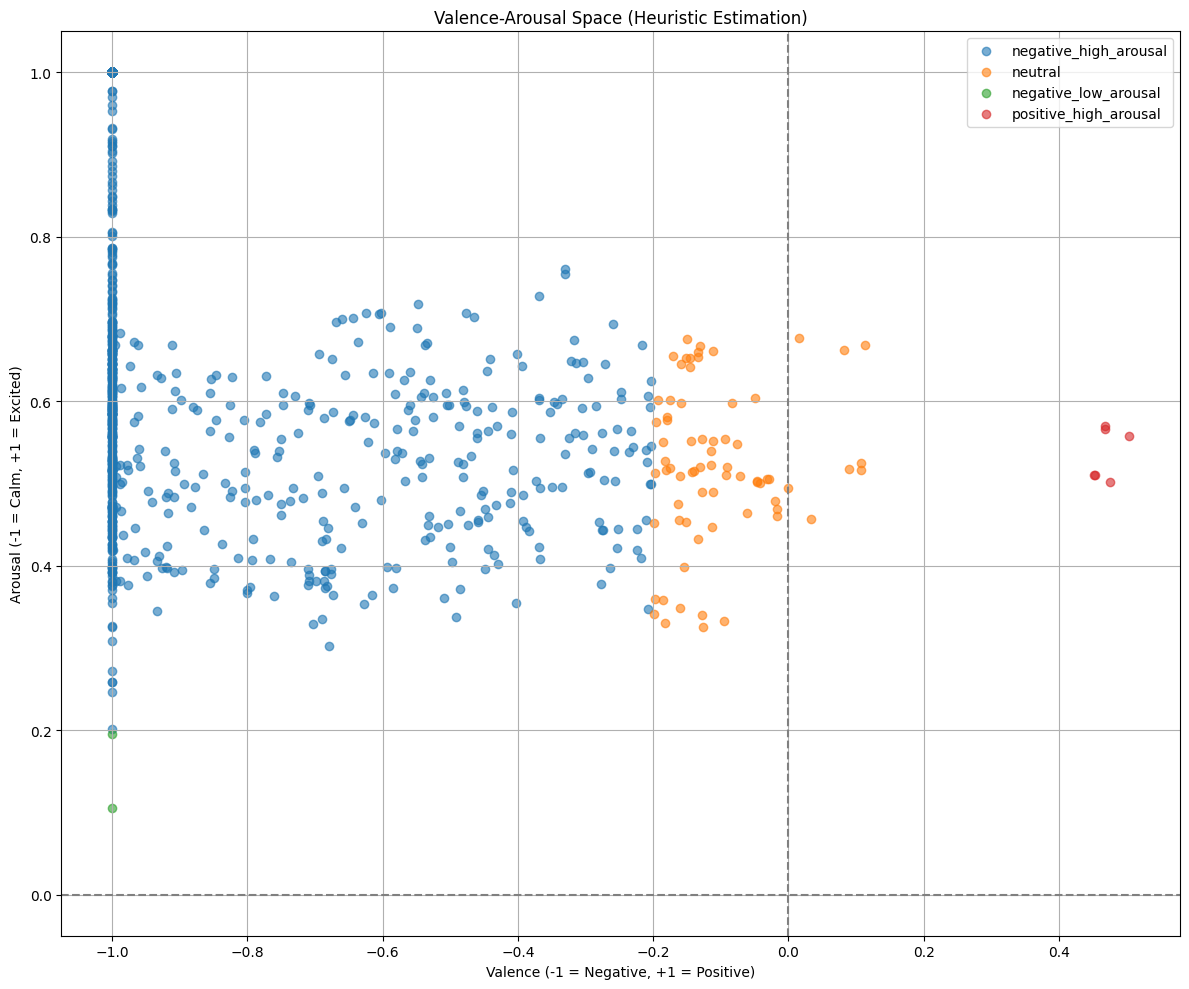

In [6]:
import cv2
import dlib
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist # For calculating Euclidean distance

# Load detector and predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(
    "models/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat"
)

# Define directories
root_input_dir = "archive_3"
root_output_dir = "processed_faces_newFinal2"
scale_factor = 12

# Emotion folders
emotion_folders = ["anger", "contempt", "disgust", "happy", "sadness", "fear", "surprise"]

# Create the root for VA-categorized output
va_output_root = os.path.join(root_output_dir, "processed_faces_VA_categorized2")
os.makedirs(va_output_root, exist_ok=True)

all_landmarks_data = []

print("Starting landmark detection and valence-arousal estimation...")

# ... (rest of imports and initializations)

# -------------------------------
# CORRECTED Heuristic Valence-Arousal Logic
# -------------------------------

# Keep EAR and MAR as they are quite standard.
def compute_eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5]) # P2-P6
    B = dist.euclidean(eye[2], eye[4]) # P3-P5
    C = dist.euclidean(eye[0], eye[3]) # P1-P4
    ear = (A + B) / (2.0 * C)
    return ear

def compute_mouth_aspect_ratio(mouth):
    A = dist.euclidean(mouth[2], mouth[10]) # Inner lip vertical: 51-57
    B = dist.euclidean(mouth[4], mouth[8])  # Inner lip vertical: 53-59
    C = dist.euclidean(mouth[0], mouth[6]) # Outer mouth horizontal: 48-54
    mar = (A + B) / (2.0 * C)
    return mar

# --- REVISED SMILE METRIC ---
def compute_smile_intensity(landmarks):
    # A simple smile intensity measure:
    # Vertical distance between upper lip (51) and lower lip (57)
    # relative to the average Y-position of mouth corners (48, 54).
    # When smiling, mouth corners (48, 54) go up (Y decreases).
    # The vertical distance (57-51) also increases (MAR).
    # Let's try the vertical position of mouth corners relative to the nose tip.
    # A smaller value (mouth corners closer to nose) indicates smile.
    
    # Average Y of mouth corners
    avg_mouth_corner_y = (landmarks[48][1] + landmarks[54][1]) / 2
    # Y of nose tip
    nose_tip_y = landmarks[30][1]
    
    # Distance between nose tip and average mouth corner Y.
    # When smiling, this distance decreases (avg_mouth_corner_y becomes smaller/closer to nose_tip_y).
    # To get a POSITIVE value for smile, we need to invert this relationship.
    # We need to find a 'neutral' position and measure deviation.
    
    # A common proxy for smile is the difference in Y-coordinates between the upper lip (51)
    # and the line connecting the mouth corners (48, 54).
    # For a smile, the line 48-54 will generally be "above" (smaller Y) the lip points 51, 57.
    # If point 51 is *below* the line segment (48,54) (i.e. Y51 > avg(Y48,Y54)), it's a frown.
    # If point 51 is *above* the line segment (48,54) (i.e. Y51 < avg(Y48,Y54)), it's a smile.
    # So, avg_mouth_corner_y - landmarks[51][1] is a good indicator for smile.
    # If this is positive, it means 51 is above the line, indicating smile.
    
    mouth_width = dist.euclidean(landmarks[48], landmarks[54])
    if mouth_width == 0: return 0
    
    # This metric should be positive for smile, negative for frown.
    # It measures how much the upper lip midpoint is 'below' the imaginary line connecting the mouth corners.
    # A higher (more positive) value means mouth corners are pulled up relative to the upper lip, indicating a smile.
    smile_val = (landmarks[51][1] - (landmarks[48][1] + landmarks[54][1]) / 2) / mouth_width
    # Important: In Dlib, Y increases downwards. So if 48/54 go up, their Y decreases.
    # If 51 is relatively lower (frown), (Y51 - avg(Y48,Y54)) would be positive. This is opposite of what we want.
    # We want a positive value for smile. So, it should be:
    smile_val = ((landmarks[48][1] + landmarks[54][1]) / 2 - landmarks[51][1]) / mouth_width
    # Now, if 48, 54 are pulled up (smaller Y), and 51 stays relatively stable or goes up less,
    # the avg Y of 48, 54 will be smaller than 51's Y, resulting in a negative smile_val for a smile.
    # So, we should negate it to make smile positive:
    smile_val = -( ((landmarks[48][1] + landmarks[54][1]) / 2) - landmarks[51][1] ) / mouth_width

    return smile_val # This should be positive for smile, negative for frown

# Keep brow raise as it is. Higher value means more raise.
def compute_brow_raise_ratio(landmarks):
    avg_brow_y_inner = (landmarks[19][1] + landmarks[24][1]) / 2
    avg_eye_y_upper = (landmarks[38][1] + landmarks[43][1]) / 2
    
    eye_distance = dist.euclidean(landmarks[36], landmarks[45])
    
    if eye_distance == 0:
        return 0
        
    brow_raise_val = (avg_eye_y_upper - avg_brow_y_inner) / eye_distance
    return brow_raise_val # This will be positive for raised brows (eyebrow Y smaller than eye Y)

# --- REVISED VALENCE-AROUSAL ESTIMATION ---
def estimate_valence_arousal(landmarks):
    left_eye = [landmarks[36], landmarks[37], landmarks[38],
                landmarks[39], landmarks[40], landmarks[41]]
    right_eye = [landmarks[42], landmarks[43], landmarks[44],
                 landmarks[45], landmarks[46], landmarks[47]]

    mouth = [landmarks[48], landmarks[49], landmarks[50], landmarks[51],
             landmarks[52], landmarks[53], landmarks[54], landmarks[55],
             landmarks[56], landmarks[57], landmarks[58], landmarks[59],
             landmarks[60], landmarks[61], landmarks[62], landmarks[63],
             landmarks[64], landmarks[65], landmarks[66], landmarks[67]]

    avg_ear = (compute_eye_aspect_ratio(left_eye) + compute_eye_aspect_ratio(right_eye)) / 2.0
    mar = compute_mouth_aspect_ratio(mouth)
    smile_intensity = compute_smile_intensity(landmarks) # Positive for smile, negative for frown
    brow_raise = compute_brow_raise_ratio(landmarks) # Positive for raised brows

    # Valence: Primarily driven by smile/frown
    # A high positive smile_intensity means positive valence.
    # A high brow_raise can indicate fear/sadness (negative valence) OR surprise (neutral/positive valence).
    # Let's simplify: smile_intensity is main valence driver. Brow raise as a slight negative modulator.
    
    # Tune these coefficients carefully. They depend on the typical ranges of your metrics.
    # For CK+ dataset:
    # A typical EAR for open eyes is ~0.3. For wide open (surprise/fear) ~0.4-0.5. For closed ~0.1-0.2.
    # A typical MAR for closed mouth is ~0.02-0.05. For open mouth (surprise) ~0.3-0.5.
    # smile_intensity: this will vary greatly. You need to observe values for neutral/smile/frown.
    # brow_raise: similarly, observe values for neutral/raised brows.

    # Let's assume typical ranges from experience for rough mapping to [-1, 1]
    # For `smile_intensity`: Let's assume neutral is around 0, strong smile around 0.1-0.2, frown around -0.1.
    valence = (smile_intensity * 8.0) # Scale it up. 0.1*8 = 0.8 (positive). -0.1*8 = -0.8 (negative).
    
    # Arousal: Driven by eye openness, mouth openness, and brow raise.
    # Higher EAR, MAR, brow_raise means higher arousal.
    # Let's define some approximate neutral thresholds:
    # neutral EAR ~ 0.28-0.3
    # neutral MAR ~ 0.03-0.05
    # neutral brow_raise ~ 0.1 (relative to eye size)
    
    arousal_ear = max(0, (avg_ear - 0.3) * 5) # If EAR > 0.3, contributes positively to arousal
    arousal_mar = max(0, (mar - 0.05) * 5)  # If MAR > 0.05, contributes positively to arousal
    arousal_brow = max(0, (brow_raise - 0.1) * 3) # If brow_raise > 0.1, contributes positively
    
    # Combine arousal components. Weights can be adjusted.
    arousal = (arousal_ear * 0.4) + (arousal_mar * 0.3) + (arousal_brow * 0.3)
    
    # Clamp values to -1 to 1. Arousal is typically 0 to 1, but your bins use positive/negative thresholds.
    valence = np.clip(valence, -1.0, 1.0)
    arousal = np.clip(arousal, -1.0, 1.0) # Will usually be >=0 with max() 
    
    return round(valence, 3), round(arousal, 3)

# ... (rest of your code remains the same as the previous correct version, including file saving logic)

# -------------------------------
# Main Processing Loop (No changes here from previous fix, just the VA methods)
# -------------------------------

for emotion in emotion_folders:
    input_emotion_path = os.path.join(root_input_dir, emotion)
    print(f"\nProcessing emotion: {emotion}...")

    for filename in os.listdir(input_emotion_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            image_path = os.path.join(input_emotion_path, filename)
            
            base_filename, ext = os.path.splitext(filename)
            output_filename_with_photo = f"{base_filename}_with_photo{ext}"
            output_filename_without_photo = f"{base_filename}_without_photo{ext}"

            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Could not read image {image_path}. Skipping.")
                continue

            print(f"   Processing file: {filename}")
            upscaled_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
            gray = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY)
            faces = detector(gray)

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(gray, face)
                landmarks_xy = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(68)]

                # Estimate valence/arousal
                valence, arousal = estimate_valence_arousal(landmarks_xy)
                
                # === Create folder based on valence-arousal quadrant ===
                if valence > 0.2 and arousal > 0.2:
                    va_bucket = "positive_high_arousal"
                elif valence > 0.2 and arousal <= 0.2:
                    va_bucket = "positive_low_arousal"
                elif valence < -0.2 and arousal > 0.2:
                    va_bucket = "negative_high_arousal"
                elif valence < -0.2 and arousal <= 0.2:
                    va_bucket = "negative_low_arousal"
                else:
                    va_bucket = "neutral"

                va_folder_path = os.path.join(va_output_root, va_bucket)
                os.makedirs(va_folder_path, exist_ok=True)

                # Draw landmarks
                drawn_image_with_photo = upscaled_image.copy()
                drawn_image_without_photo = np.zeros(upscaled_image.shape, dtype=np.uint8)

                nose_x = landmarks.part(30).x
                nose_y = landmarks.part(30).y
                img_h, img_w = drawn_image_with_photo.shape[:2]
                cv2.line(drawn_image_with_photo, (nose_x, 0), (nose_x, img_h), (0, 255, 0), 1)
                cv2.line(drawn_image_with_photo, (0, nose_y), (img_w, nose_y), (0, 255, 0), 1)

                drawn_index = 1
                seen = set()
                for n, (x, y) in enumerate(landmarks_xy):
                    if (x, y) in seen:
                        continue
                    seen.add((x, y))

                    circle_color = (0, 0, 255)
                    circle_radius = 2
                    fill_type = -1
                    text_font = cv2.FONT_HERSHEY_SIMPLEX
                    text_scale = 0.35

                    offset_x, offset_y = -6, 10
                    if n in [37, 38, 39, 43, 44, 45]:
                        offset_y = -10
                    elif n == 49:
                        offset_x = -20; offset_y = 6
                    elif n == 50:
                        offset_x = 0; offset_y = -8
                    elif n == 65:
                        offset_x = -14; offset_y = 10
                    elif 48 <= n <= 54:
                        offset_y = -8
                    elif 55 <= n <= 59:
                        offset_y = 10
                    elif 60 <= n <= 64:
                        offset_y = -8
                    elif 65 <= n <= 67:
                        offset_y = 10

                    cv2.circle(drawn_image_with_photo, (x, y), circle_radius, circle_color, fill_type)
                    cv2.putText(drawn_image_with_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                 text_font, text_scale, (0, 0, 0), 1, cv2.LINE_AA)
                    cv2.circle(drawn_image_without_photo, (x, y), circle_radius, (255, 255, 255), fill_type)
                    cv2.putText(drawn_image_without_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                 text_font, text_scale, (255, 255, 255), 1, cv2.LINE_AA)

                    drawn_index += 1

                cv2.imwrite(os.path.join(va_folder_path, output_filename_with_photo), drawn_image_with_photo)
                cv2.imwrite(os.path.join(va_folder_path, output_filename_without_photo), drawn_image_without_photo)

                # Store to CSV
                landmark_row = {'emotion': emotion, 'filename': filename, 'valence': valence, 'arousal': arousal, 'va_bucket': va_bucket}
                for n, (x, y) in enumerate(landmarks_xy):
                    landmark_row[f'landmark_{n}_x'] = x
                    landmark_row[f'landmark_{n}_y'] = y
                all_landmarks_data.append(landmark_row)

            else:
                print(f"   No face detected in {filename} from {emotion} folder.")

# -------------------------------
# Save CSV
# -------------------------------
if all_landmarks_data:
    df = pd.DataFrame(all_landmarks_data)
    csv_output_path = os.path.join(root_output_dir, "facial_landmarks_data.csv")
    df.to_csv(csv_output_path, index=False)
    print(f"\n✅ All facial landmark coordinates and VA values saved to: {csv_output_path}")
else:
    print("\n❌ No landmark data collected. Check input folders or face detection.")

# -------------------------------
# Plot Valence-Arousal Space
# -------------------------------
try:
    df = pd.read_csv(os.path.join(root_output_dir, "facial_landmarks_data.csv"))

    plt.figure(figsize=(12, 10))
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')

    for bucket in df['va_bucket'].unique():
        subset = df[df['va_bucket'] == bucket]
        plt.scatter(subset['valence'], subset['arousal'], label=bucket, alpha=0.6)

    plt.xlabel('Valence (-1 = Negative, +1 = Positive)')
    plt.ylabel('Arousal (-1 = Calm, +1 = Excited)')
    plt.title('Valence-Arousal Space (Heuristic Estimation)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("⚠️ Could not display Valence-Arousal plot:", str(e))

Starting landmark detection and valence-arousal estimation...

Processing emotion: anger...
   Processing file: S010_004_00000017.png
   Processing file: S010_004_00000018.png
   Processing file: S010_004_00000019.png
   Processing file: S011_004_00000019.png
   Processing file: S011_004_00000020.png
   Processing file: S011_004_00000021.png
   Processing file: S014_003_00000028.png
   Processing file: S014_003_00000029.png
   Processing file: S014_003_00000030.png
   Processing file: S022_005_00000030.png
   Processing file: S022_005_00000031.png
   Processing file: S022_005_00000032.png
   Processing file: S026_003_00000013.png
   Processing file: S026_003_00000014.png
   Processing file: S026_003_00000015.png
   Processing file: S028_001_00000022.png
   Processing file: S028_001_00000023.png
   Processing file: S028_001_00000024.png
   Processing file: S029_001_00000017.png
   Processing file: S029_001_00000018.png
   Processing file: S029_001_00000019.png
   Processing file: S032_0

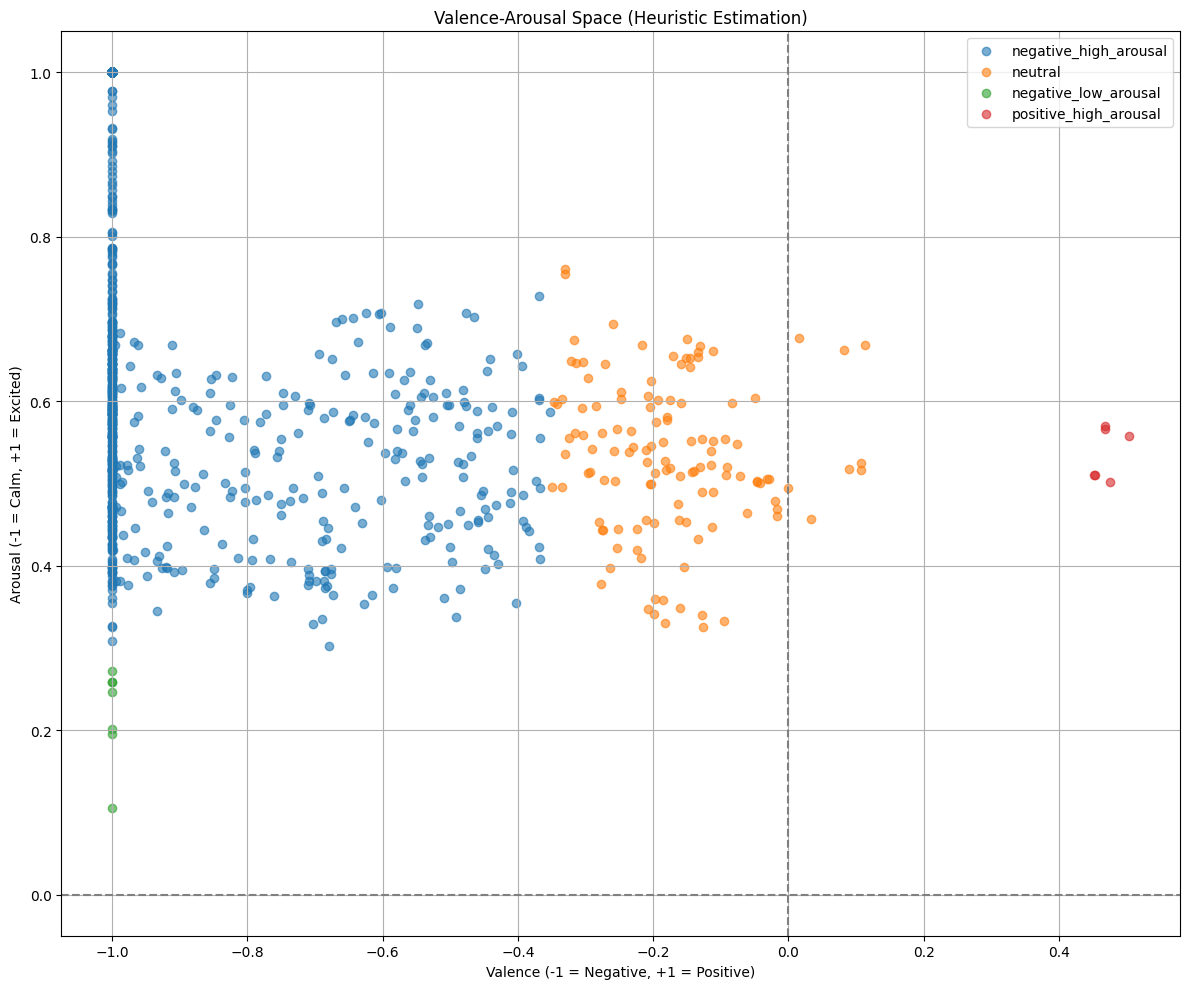

In [ ]:
import cv2
import dlib
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist # For calculating Euclidean distance

# Load detector and predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(
    "models/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat"
)

# Define directories
root_input_dir = "archive_3"
root_output_dir = "processed_faces_newFinal2"
scale_factor = 12

# Emotion folders
emotion_folders = ["anger", "contempt", "disgust", "happy", "sadness", "fear", "surprise"]

# Create the root for VA-categorized output
va_output_root = os.path.join(root_output_dir, "processed_faces_VA_categorized5")
os.makedirs(va_output_root, exist_ok=True)

all_landmarks_data = []

print("Starting landmark detection and valence-arousal estimation...")

# ... (rest of imports and initializations)

# -------------------------------
# CORRECTED Heuristic Valence-Arousal Logic
# -------------------------------

# Keep EAR and MAR as they are quite standard.
def compute_eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5]) # P2-P6
    B = dist.euclidean(eye[2], eye[4]) # P3-P5
    C = dist.euclidean(eye[0], eye[3]) # P1-P4
    ear = (A + B) / (2.0 * C)
    return ear

def compute_mouth_aspect_ratio(mouth):
    A = dist.euclidean(mouth[2], mouth[10]) # Inner lip vertical: 51-57
    B = dist.euclidean(mouth[4], mouth[8])  # Inner lip vertical: 53-59
    C = dist.euclidean(mouth[0], mouth[6]) # Outer mouth horizontal: 48-54
    mar = (A + B) / (2.0 * C)
    return mar

# --- REVISED SMILE METRIC ---
def compute_smile_intensity(landmarks):
    # A simple smile intensity measure:
    # Vertical distance between upper lip (51) and lower lip (57)
    # relative to the average Y-position of mouth corners (48, 54).
    # When smiling, mouth corners (48, 54) go up (Y decreases).
    # The vertical distance (57-51) also increases (MAR).
    # Let's try the vertical position of mouth corners relative to the nose tip.
    # A smaller value (mouth corners closer to nose) indicates smile.
    
    # Average Y of mouth corners
    avg_mouth_corner_y = (landmarks[48][1] + landmarks[54][1]) / 2
    # Y of nose tip
    nose_tip_y = landmarks[30][1]
    
    # Distance between nose tip and average mouth corner Y.
    # When smiling, this distance decreases (avg_mouth_corner_y becomes smaller/closer to nose_tip_y).
    # To get a POSITIVE value for smile, we need to invert this relationship.
    # We need to find a 'neutral' position and measure deviation.
    
    # A common proxy for smile is the difference in Y-coordinates between the upper lip (51)
    # and the line connecting the mouth corners (48, 54).
    # For a smile, the line 48-54 will generally be "above" (smaller Y) the lip points 51, 57.
    # If point 51 is *below* the line segment (48,54) (i.e. Y51 > avg(Y48,Y54)), it's a frown.
    # If point 51 is *above* the line segment (48,54) (i.e. Y51 < avg(Y48,Y54)), it's a smile.
    # So, avg_mouth_corner_y - landmarks[51][1] is a good indicator for smile.
    # If this is positive, it means 51 is above the line, indicating smile.
    
    mouth_width = dist.euclidean(landmarks[48], landmarks[54])
    if mouth_width == 0: return 0
    
    # This metric should be positive for smile, negative for frown.
    # It measures how much the upper lip midpoint is 'below' the imaginary line connecting the mouth corners.
    # A higher (more positive) value means mouth corners are pulled up relative to the upper lip, indicating a smile.
    smile_val = (landmarks[51][1] - (landmarks[48][1] + landmarks[54][1]) / 2) / mouth_width
    # Important: In Dlib, Y increases downwards. So if 48/54 go up, their Y decreases.
    # If 51 is relatively lower (frown), (Y51 - avg(Y48,Y54)) would be positive. This is opposite of what we want.
    # We want a positive value for smile. So, it should be:
    smile_val = ((landmarks[48][1] + landmarks[54][1]) / 2 - landmarks[51][1]) / mouth_width
    # Now, if 48, 54 are pulled up (smaller Y), and 51 stays relatively stable or goes up less,
    # the avg Y of 48, 54 will be smaller than 51's Y, resulting in a negative smile_val for a smile.
    # So, we should negate it to make smile positive:
    smile_val = -( ((landmarks[48][1] + landmarks[54][1]) / 2) - landmarks[51][1] ) / mouth_width

    return smile_val # This should be positive for smile, negative for frown

# Keep brow raise as it is. Higher value means more raise.
def compute_brow_raise_ratio(landmarks):
    avg_brow_y_inner = (landmarks[19][1] + landmarks[24][1]) / 2
    avg_eye_y_upper = (landmarks[38][1] + landmarks[43][1]) / 2
    
    eye_distance = dist.euclidean(landmarks[36], landmarks[45])
    
    if eye_distance == 0:
        return 0
        
    brow_raise_val = (avg_eye_y_upper - avg_brow_y_inner) / eye_distance
    return brow_raise_val # This will be positive for raised brows (eyebrow Y smaller than eye Y)

# --- REVISED VALENCE-AROUSAL ESTIMATION ---
def estimate_valence_arousal(landmarks):
    left_eye = [landmarks[36], landmarks[37], landmarks[38],
                landmarks[39], landmarks[40], landmarks[41]]
    right_eye = [landmarks[42], landmarks[43], landmarks[44],
                 landmarks[45], landmarks[46], landmarks[47]]

    mouth = [landmarks[48], landmarks[49], landmarks[50], landmarks[51],
             landmarks[52], landmarks[53], landmarks[54], landmarks[55],
             landmarks[56], landmarks[57], landmarks[58], landmarks[59],
             landmarks[60], landmarks[61], landmarks[62], landmarks[63],
             landmarks[64], landmarks[65], landmarks[66], landmarks[67]]

    avg_ear = (compute_eye_aspect_ratio(left_eye) + compute_eye_aspect_ratio(right_eye)) / 2.0
    mar = compute_mouth_aspect_ratio(mouth)
    smile_intensity = compute_smile_intensity(landmarks) # Positive for smile, negative for frown
    brow_raise = compute_brow_raise_ratio(landmarks) # Positive for raised brows

    # Valence: Primarily driven by smile/frown
    # A high positive smile_intensity means positive valence.
    # A high brow_raise can indicate fear/sadness (negative valence) OR surprise (neutral/positive valence).
    # Let's simplify: smile_intensity is main valence driver. Brow raise as a slight negative modulator.
    
    # Tune these coefficients carefully. They depend on the typical ranges of your metrics.
    # For CK+ dataset:
    # A typical EAR for open eyes is ~0.3. For wide open (surprise/fear) ~0.4-0.5. For closed ~0.1-0.2.
    # A typical MAR for closed mouth is ~0.02-0.05. For open mouth (surprise) ~0.3-0.5.
    # smile_intensity: this will vary greatly. You need to observe values for neutral/smile/frown.
    # brow_raise: similarly, observe values for neutral/raised brows.

    # Let's assume typical ranges from experience for rough mapping to [-1, 1]
    # For `smile_intensity`: Let's assume neutral is around 0, strong smile around 0.1-0.2, frown around -0.1.
    valence = (smile_intensity * 8.0) # Scale it up. 0.1*8 = 0.8 (positive). -0.1*8 = -0.8 (negative).
    
    # Arousal: Driven by eye openness, mouth openness, and brow raise.
    # Higher EAR, MAR, brow_raise means higher arousal.
    # Let's define some approximate neutral thresholds:
    # neutral EAR ~ 0.28-0.3
    # neutral MAR ~ 0.03-0.05
    # neutral brow_raise ~ 0.1 (relative to eye size)
    
    arousal_ear = max(0, (avg_ear - 0.3) * 5) # If EAR > 0.3, contributes positively to arousal
    arousal_mar = max(0, (mar - 0.05) * 5)  # If MAR > 0.05, contributes positively to arousal
    arousal_brow = max(0, (brow_raise - 0.1) * 3) # If brow_raise > 0.1, contributes positively
    
    # Combine arousal components. Weights can be adjusted.
    arousal = (arousal_ear * 0.4) + (arousal_mar * 0.3) + (arousal_brow * 0.3)
    
    # Clamp values to -1 to 1. Arousal is typically 0 to 1, but your bins use positive/negative thresholds.
    valence = np.clip(valence, -1.0, 1.0)
    arousal = np.clip(arousal, -1.0, 1.0) # Will usually be >=0 with max() 
    
    return round(valence, 3), round(arousal, 3)



# -------------------------------
# Main Processing Loop (No changes here from previous fix, just the VA methods)
# -------------------------------

for emotion in emotion_folders:
    input_emotion_path = os.path.join(root_input_dir, emotion)
    print(f"\nProcessing emotion: {emotion}...")

    for filename in os.listdir(input_emotion_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            image_path = os.path.join(input_emotion_path, filename)
            
            base_filename, ext = os.path.splitext(filename)
            output_filename_with_photo = f"{base_filename}_with_photo{ext}"
            output_filename_without_photo = f"{base_filename}_without_photo{ext}"

            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Could not read image {image_path}. Skipping.")
                continue

            print(f"   Processing file: {filename}")
            upscaled_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
            gray = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY)
            faces = detector(gray)

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(gray, face)
                landmarks_xy = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(68)]

                # Estimate valence/arousal
                valence, arousal = estimate_valence_arousal(landmarks_xy)
                
                # === Create folder based on valence-arousal quadrant ===
                if valence > 0.35:
                    if arousal > 0.3:
                        va_bucket = "positive_high_arousal"
                    else:
                        va_bucket = "positive_low_arousal"
                elif valence < -0.35:
                    if arousal > 0.3:
                        va_bucket = "negative_high_arousal"
                    else:
                        va_bucket = "negative_low_arousal"
                else:
                    va_bucket = "neutral"


                va_folder_path = os.path.join(va_output_root, va_bucket)
                os.makedirs(va_folder_path, exist_ok=True)

                # Draw landmarks
                drawn_image_with_photo = upscaled_image.copy()
                drawn_image_without_photo = np.zeros(upscaled_image.shape, dtype=np.uint8)

                nose_x = landmarks.part(30).x
                nose_y = landmarks.part(30).y
                img_h, img_w = drawn_image_with_photo.shape[:2]
                cv2.line(drawn_image_with_photo, (nose_x, 0), (nose_x, img_h), (0, 255, 0), 1)
                cv2.line(drawn_image_with_photo, (0, nose_y), (img_w, nose_y), (0, 255, 0), 1)

                drawn_index = 1
                seen = set()
                for n, (x, y) in enumerate(landmarks_xy):
                    if (x, y) in seen:
                        continue
                    seen.add((x, y))

                    circle_color = (0, 0, 255)
                    circle_radius = 2
                    fill_type = -1
                    text_font = cv2.FONT_HERSHEY_SIMPLEX
                    text_scale = 0.35

                    offset_x, offset_y = -6, 10
                    if n in [37, 38, 39, 43, 44, 45]:
                        offset_y = -10
                    elif n == 49:
                        offset_x = -20; offset_y = 6
                    elif n == 50:
                        offset_x = 0; offset_y = -8
                    elif n == 65:
                        offset_x = -14; offset_y = 10
                    elif 48 <= n <= 54:
                        offset_y = -8
                    elif 55 <= n <= 59:
                        offset_y = 10
                    elif 60 <= n <= 64:
                        offset_y = -8
                    elif 65 <= n <= 67:
                        offset_y = 10

                    cv2.circle(drawn_image_with_photo, (x, y), circle_radius, circle_color, fill_type)
                    cv2.putText(drawn_image_with_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                 text_font, text_scale, (0, 0, 0), 1, cv2.LINE_AA)
                    cv2.circle(drawn_image_without_photo, (x, y), circle_radius, (255, 255, 255), fill_type)
                    cv2.putText(drawn_image_without_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                 text_font, text_scale, (255, 255, 255), 1, cv2.LINE_AA)

                    drawn_index += 1

                cv2.imwrite(os.path.join(va_folder_path, output_filename_with_photo), drawn_image_with_photo)
                cv2.imwrite(os.path.join(va_folder_path, output_filename_without_photo), drawn_image_without_photo)

                # Store to CSV
                landmark_row = {'emotion': emotion, 'filename': filename, 'valence': valence, 'arousal': arousal, 'va_bucket': va_bucket}
                for n, (x, y) in enumerate(landmarks_xy):
                    landmark_row[f'landmark_{n}_x'] = x
                    landmark_row[f'landmark_{n}_y'] = y
                all_landmarks_data.append(landmark_row)

            else:
                print(f"   No face detected in {filename} from {emotion} folder.")

# -------------------------------
# Save CSV
# -------------------------------
if all_landmarks_data:
    df = pd.DataFrame(all_landmarks_data)
    csv_output_path = os.path.join(root_output_dir, "facial_landmarks_data.csv")
    df.to_csv(csv_output_path, index=False)
    print(f"\n✅ All facial landmark coordinates and VA values saved to: {csv_output_path}")
else:
    print("\n❌ No landmark data collected. Check input folders or face detection.")

# -------------------------------
# Plot Valence-Arousal Space
# -------------------------------
try:
    df = pd.read_csv(os.path.join(root_output_dir, "facial_landmarks_data.csv"))

    plt.figure(figsize=(12, 10))
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')

    for bucket in df['va_bucket'].unique():
        subset = df[df['va_bucket'] == bucket]
        plt.scatter(subset['valence'], subset['arousal'], label=bucket, alpha=0.6)

    plt.xlabel('Valence (-1 = Negative, +1 = Positive)')
    plt.ylabel('Arousal (-1 = Calm, +1 = Excited)')
    plt.title('Valence-Arousal Space (Heuristic Estimation)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("⚠️ Could not display Valence-Arousal plot:", str(e))

In [1]:
import cv2
import dlib
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist
from skimage.feature import hog # New import for HOG
from skimage import exposure # New import for HOG visualization (optional)

# Load detector and predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(
    "models/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat"
)

# Define directories
root_input_dir = "archive_3"
root_output_dir = "processed_faces_newFinal2"
scale_factor = 12 # This was for upscaling for Dlib detector. Might need adjustment.

# Emotion folders
emotion_folders = ["anger", "contempt", "disgust", "happy", "sadness", "fear", "surprise"]

# Create the root for VA-categorized output (keeping this for structure, but we're focusing on features now)
va_output_root = os.path.join(root_output_dir, "processed_faces_VA_categorized5")
os.makedirs(va_output_root, exist_ok=True)

# List to store all extracted features and metadata
all_feature_data = []

print("Starting micro-level feature extraction (Low-Level: HOG)...")

# --- Feature Calculation Functions (from your previous code) ---
def compute_eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5]) # P2-P6
    B = dist.euclidean(eye[2], eye[4]) # P3-P5
    C = dist.euclidean(eye[0], eye[3]) # P1-P4
    ear = (A + B) / (2.0 * C)
    return ear

def compute_mouth_aspect_ratio(mouth):
    A = dist.euclidean(mouth[2], mouth[10]) # Inner lip vertical: 51-57
    B = dist.euclidean(mouth[4], mouth[8])  # Inner lip vertical: 53-59
    C = dist.euclidean(mouth[0], mouth[6]) # Outer mouth horizontal: 48-54
    if C == 0: return 0.0 # Prevent division by zero
    mar = (A + B) / (2.0 * C)
    return mar

def compute_smile_intensity(landmarks):
    y48 = landmarks[48][1]
    y54 = landmarks[54][1]
    y51 = landmarks[51][1]
    avg_corner_y = (y48 + y54) / 2
    mouth_width = dist.euclidean(landmarks[48], landmarks[54])
    if mouth_width == 0: return 0.0
    smile_val = (avg_corner_y - y51) / mouth_width
    return smile_val

def compute_brow_raise_ratio(landmarks):
    avg_brow_y_inner = (landmarks[19][1] + landmarks[24][1]) / 2
    avg_eye_y_upper = (landmarks[38][1] + landmarks[43][1]) / 2
    eye_distance = dist.euclidean(landmarks[36], landmarks[45])
    if eye_distance == 0: return 0.0
    brow_raise_val = (avg_eye_y_upper - avg_brow_y_inner) / eye_distance
    return brow_raise_val

# --- Heuristic VA Estimation (keeping for consistency, but not our main focus now) ---
def estimate_valence_arousal(landmarks):
    left_eye = [landmarks[36], landmarks[37], landmarks[38], landmarks[39], landmarks[40], landmarks[41]]
    right_eye = [landmarks[42], landmarks[43], landmarks[44], landmarks[45], landmarks[46], landmarks[47]]
    mouth = [landmarks[48], landmarks[49], landmarks[50], landmarks[51],
             landmarks[52], landmarks[53], landmarks[54], landmarks[55],
             landmarks[56], landmarks[57], landmarks[58], landmarks[59],
             landmarks[60], landmarks[61], landmarks[62], landmarks[63],
             landmarks[64], landmarks[65], landmarks[66], landmarks[67]]

    avg_ear = (compute_eye_aspect_ratio(left_eye) + compute_eye_aspect_ratio(right_eye)) / 2.0
    mar = compute_mouth_aspect_ratio(mouth)
    smile_intensity = compute_smile_intensity(landmarks)
    brow_raise = compute_brow_raise_ratio(landmarks)
    
    # Placeholder VA estimation (adjust based on your diagnosis if you plan to use this for categorization)
    valence = np.clip(smile_intensity * 8.0, -1.0, 1.0) 
    arousal = np.clip((max(0, (avg_ear - 0.28) * 5.0) * 0.4) + \
                      (max(0, (mar - 0.03) * 5.0) * 0.3) + \
                      (max(0, (brow_raise - 0.1) * 3.0) * 0.3), -1.0, 1.0)
    
    return round(valence, 3), round(arousal, 3)

# --- NEW: Function to extract HOG features ---
def extract_hog_features(image_region):
    # Ensure the image region is grayscale for HOG
    if len(image_region.shape) == 3:
        image_region = cv2.cvtColor(image_region, cv2.COLOR_BGR2GRAY)
    
    # HOG parameters (can be tuned)
    # orientations: number of bins for the orientation histogram
    # pixels_per_cell: size of the cell in pixels (e.g., 8x8)
    # cells_per_block: number of cells in each block (e.g., 2x2)
    # block_norm: normalization method ('L2-Hys' is common)
    
    # It's important to resize the face region to a consistent size
    # before computing HOG, so that the feature vector has a fixed length.
    # A common size is 64x128 or 128x128 for facial features.
    
    hog_image_size = (128, 128) # Standardize face image size for HOG
    resized_region = cv2.resize(image_region, hog_image_size, interpolation=cv2.INTER_AREA)

    # `feature_vector=True` means it returns a 1D array of features.
    # `visualize=True` returns an image of the HOG gradients (for debugging/visualization).
    hog_features, hog_image = hog(resized_region, orientations=9, pixels_per_cell=(8, 8),
                                   cells_per_block=(2, 2), block_norm='L2-Hys',
                                   visualize=True, feature_vector=True)
    
    return hog_features, hog_image, resized_region

# -------------------------------
# Main Processing Loop for Feature Extraction
# -------------------------------

# The main loop will now collect all features and save them.
# The `va_bucket` logic is still there but is secondary to feature extraction.

for emotion in emotion_folders:
    input_emotion_path = os.path.join(root_input_dir, emotion)
    print(f"\nProcessing emotion: {emotion} for feature extraction...")

    for filename in os.listdir(input_emotion_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            image_path = os.path.join(input_emotion_path, filename)
            
            base_filename, ext = os.path.splitext(filename)
            
            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Could not read image {image_path}. Skipping.")
                continue

            # Original upscaling for Dlib detection
            upscaled_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
            gray = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY)
            faces = detector(gray)

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(gray, face)
                landmarks_xy = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(68)]

                # Extract the face region using the detected bounding box
                x1, y1, x2, y2 = face.left(), face.top(), face.right(), face.bottom()
                
                # Add padding to the face bounding box to ensure it captures more context
                # This helps with features like HOG if the face is too tightly cropped
                padding = 30 # pixels
                x1_padded = max(0, x1 - padding)
                y1_padded = max(0, y1 - padding)
                x2_padded = min(gray.shape[1], x2 + padding)
                y2_padded = min(gray.shape[0], y2 + padding)

                face_roi = gray[y1_padded:y2_padded, x1_padded:x2_padded]

                if face_roi.size == 0:
                    print(f"   Skipping {filename}: Empty face ROI after padding.")
                    continue

                # --- LOW-LEVEL FEATURE EXTRACTION: HOG ---
                hog_features, hog_image_vis, resized_face_for_hog = extract_hog_features(face_roi.copy())
                
                # --- Store features and metadata ---
                feature_row = {
                    'emotion': emotion,
                    'filename': filename,
                    # HOG features will be stored as a list or string, which pandas can handle
                    'hog_features': hog_features.tolist(), 
                }
                
                # Also include previous landmark data and VA if desired for multimodal later
                # For now, let's keep it clean to focus on HOG
                # landmark_row = {'emotion': emotion, 'filename': filename, 'valence': valence, 'arousal': arousal, 'va_bucket': va_bucket}
                # for n, (x, y) in enumerate(landmarks_xy):
                #     landmark_row[f'landmark_{n}_x'] = x
                #     landmark_row[f'landmark_{n}_y'] = y
                # feature_row.update(landmark_row) # This would merge them

                all_feature_data.append(feature_row)

                # --- Optional: Save HOG visualization for inspection ---
                hog_vis_output_dir = os.path.join(root_output_dir, "hog_visualizations")
                os.makedirs(hog_vis_output_dir, exist_ok=True)
                
                # Rescale histogram for better display
                hog_image_rescaled = exposure.rescale_intensity(hog_image_vis, in_range=(0, 1))
                hog_image_rescaled = (hog_image_rescaled * 255).astype("uint8")
                cv2.imwrite(os.path.join(hog_vis_output_dir, f"{base_filename}_hog.png"), hog_image_rescaled)
                
                # Save the resized face used for HOG calculation
                cv2.imwrite(os.path.join(hog_vis_output_dir, f"{base_filename}_face_roi_resized.png"), resized_face_for_hog)

                print(f"   Extracted HOG for {filename}. HOG feature vector length: {len(hog_features)}")

            else:
                print(f"   No face detected in {filename} from {emotion} folder. Skipping feature extraction.")

# -------------------------------
# Save All Feature Data to CSV
# -------------------------------
if all_feature_data:
    df_features = pd.DataFrame(all_feature_data)
    features_csv_path = os.path.join(root_output_dir, "extracted_low_level_features.csv")
    df_features.to_csv(features_csv_path, index=False)
    print(f"\n✅ All low-level (HOG) features saved to: {features_csv_path}")
else:
    print("\n❌ No feature data collected. Check input folders or face detection.")

print("\nSegment 1 (Low-Level Feature Extraction - HOG) complete.")

Starting micro-level feature extraction (Low-Level: HOG)...

Processing emotion: anger for feature extraction...
   Extracted HOG for S010_004_00000017.png. HOG feature vector length: 8100
   Extracted HOG for S010_004_00000018.png. HOG feature vector length: 8100
   Extracted HOG for S010_004_00000019.png. HOG feature vector length: 8100
   Extracted HOG for S011_004_00000019.png. HOG feature vector length: 8100
   Extracted HOG for S011_004_00000020.png. HOG feature vector length: 8100
   Extracted HOG for S011_004_00000021.png. HOG feature vector length: 8100
   Extracted HOG for S014_003_00000028.png. HOG feature vector length: 8100
   Extracted HOG for S014_003_00000029.png. HOG feature vector length: 8100
   Extracted HOG for S014_003_00000030.png. HOG feature vector length: 8100
   Extracted HOG for S022_005_00000030.png. HOG feature vector length: 8100
   Extracted HOG for S022_005_00000031.png. HOG feature vector length: 8100
   Extracted HOG for S022_005_00000032.png. HOG fea

In [2]:
import cv2
import dlib
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist
from skimage.feature import hog
from skimage import exposure
from tqdm import tqdm # Import tqdm for progress bar

# Load detector and predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(
    "models/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat"
)

# Define directories
root_input_dir = "archive_3"
root_output_dir = "processed_faces_newFinal2"
scale_factor = 12 

# Emotion folders
emotion_folders = ["anger", "contempt", "disgust", "happy", "sadness", "fear", "surprise"]

# Create the root for VA-categorized output (keeping this for structure, but main focus is features)
va_output_root = os.path.join(root_output_dir, "processed_faces_VA_categorized5")
os.makedirs(va_output_root, exist_ok=True)

# List to store all extracted features and metadata
all_feature_data = []

print("Starting micro-level feature extraction (Low-Level: HOG & Mid-Level: Geometric)...")

# --- Feature Calculation Functions (Existing and New) ---

def compute_eye_aspect_ratio(eye):
    # vertical eye landmarks (x,y)
    A = dist.euclidean(eye[1], eye[5]) # P2-P6
    B = dist.euclidean(eye[2], eye[4]) # P3-P5
    # horizontal eye landmark (x,y)
    C = dist.euclidean(eye[0], eye[3]) # P1-P4 (corner to corner)
    ear = (A + B) / (2.0 * C)
    return ear

def compute_mouth_aspect_ratio(mouth):
    # Inner lip vertical distances (51-57 and 53-59)
    A = dist.euclidean(mouth[2], mouth[10]) # 51-57
    B = dist.euclidean(mouth[4], mouth[8])  # 53-59
    # Outer mouth horizontal distance (48-54)
    C = dist.euclidean(mouth[0], mouth[6]) # 48-54 (mouth corners)
    if C == 0: return 0.0 # Prevent division by zero
    mar = (A + B) / (2.0 * C)
    return mar

def compute_smile_intensity(landmarks):
    # Measures the curvature of the outer lip line: positive for smile, negative for frown.
    y48, y54, y51 = landmarks[48][1], landmarks[54][1], landmarks[51][1]
    avg_corner_y = (y48 + y54) / 2
    mouth_width = dist.euclidean(landmarks[48], landmarks[54])
    if mouth_width == 0: return 0.0 
    smile_val = (avg_corner_y - y51) / mouth_width # Positive for smile
    return smile_val

def compute_brow_raise_ratio(landmarks):
    # Measures the vertical distance between upper eyelid and eyebrow: positive for raised brows.
    avg_brow_y_inner = (landmarks[19][1] + landmarks[24][1]) / 2
    avg_eye_y_upper = (landmarks[38][1] + landmarks[43][1]) / 2
    eye_distance = dist.euclidean(landmarks[36], landmarks[45])
    if eye_distance == 0: return 0.0
    brow_raise_val = (avg_eye_y_upper - avg_brow_y_inner) / eye_distance
    return brow_raise_val

# --- NEW: Geometric Feature Functions ---

def compute_geometric_features(landmarks):
    features = {}

    # Define common anchor points for normalization
    # Inter-ocular distance (distance between center of eyes)
    eye_left_center = np.mean([landmarks[37], landmarks[38], landmarks[40], landmarks[41]], axis=0) # avg of inner/outer upper/lower
    eye_right_center = np.mean([landmarks[43], landmarks[44], landmarks[46], landmarks[47]], axis=0)
    inter_ocular_dist = dist.euclidean(landmarks[36], landmarks[45]) # Distance between outer eye corners (36, 45) is also good

    if inter_ocular_dist == 0: # Prevent division by zero if face not detected well
        return {f'geo_feat_{i}': 0.0 for i in range(20)} # Return dummy features if base is zero

    # 1. Eye features (normalized by inter_ocular_dist)
    left_eye_landmarks = [landmarks[36], landmarks[37], landmarks[38], landmarks[39], landmarks[40], landmarks[41]]
    right_eye_landmarks = [landmarks[42], landmarks[43], landmarks[44], landmarks[45], landmarks[46], landmarks[47]]
    features['ear_left'] = compute_eye_aspect_ratio(left_eye_landmarks)
    features['ear_right'] = compute_eye_aspect_ratio(right_eye_landmarks)
    
    # 2. Mouth features (normalized by mouth width)
    mouth_landmarks_list = [landmarks[48], landmarks[49], landmarks[50], landmarks[51],
                           landmarks[52], landmarks[53], landmarks[54], landmarks[55],
                           landmarks[56], landmarks[57], landmarks[58], landmarks[59],
                           landmarks[60], landmarks[61], landmarks[62], landmarks[63],
                           landmarks[64], landmarks[65], landmarks[66], landmarks[67]]
    features['mar'] = compute_mouth_aspect_ratio(mouth_landmarks_list)
    features['smile_intensity'] = compute_smile_intensity(landmarks) # Your existing smile metric

    # 3. Eyebrow features (normalized by eye distance)
    features['brow_raise'] = compute_brow_raise_ratio(landmarks) # Your existing brow raise metric

    # 4. Additional significant distances/ratios
    #   a. Mouth-to-nose distance (lower lip to nose tip), normalized by inter_ocular_dist
    features['mouth_nose_dist'] = dist.euclidean(landmarks[57], landmarks[30]) / inter_ocular_dist

    #   b. Distance between eyebrows (21-22 for furrowing), normalized by inter_ocular_dist
    features['inter_brow_dist'] = dist.euclidean(landmarks[21], landmarks[22]) / inter_ocular_dist
    
    #   c. Cheek raise (distance between mouth corner and lower eye lid)
    #      A decrease can indicate cheek raise (as in smiles, points move up)
    features['cheek_raise_left'] = dist.euclidean(landmarks[40], landmarks[48]) / inter_ocular_dist
    features['cheek_raise_right'] = dist.euclidean(landmarks[47], landmarks[54]) / inter_ocular_dist

    #   d. Jaw Drop (distance from chin (8) to nose tip (30))
    features['jaw_drop'] = dist.euclidean(landmarks[8], landmarks[30]) / inter_ocular_dist

    #   e. Inner eyebrow vertical distance (sadness)
    features['inner_brow_vdist'] = (landmarks[19][1] - landmarks[27][1]) / inter_ocular_dist # 19-27 and 24-27
    features['inner_brow_vdist_right'] = (landmarks[24][1] - landmarks[27][1]) / inter_ocular_dist # To check asymmetry

    #   f. Eye width (already implicitly in EAR denominator, but explicit can be useful)
    features['eye_width_left'] = dist.euclidean(landmarks[36], landmarks[39]) / inter_ocular_dist
    features['eye_width_right'] = dist.euclidean(landmarks[42], landmarks[45]) / inter_ocular_dist

    #   g. Mouth width to interocular distance ratio (can change with expressions)
    features['mouth_width_ratio'] = dist.euclidean(landmarks[48], landmarks[54]) / inter_ocular_dist
    
    # You can add more features here! Examples:
    # - Angles: e.g., angle of mouth corners, angle of eyebrow slant. Requires trigonometry.
    # - Area of mouth/eye region. Requires convex hull or polygon area calculation.

    # Convert dictionary to a consistent list/array for storage
    # Order matters for ML models, so a defined list of keys is good.
    feature_names = [
        'ear_left', 'ear_right', 'mar', 'smile_intensity', 'brow_raise',
        'mouth_nose_dist', 'inter_brow_dist', 'cheek_raise_left', 'cheek_raise_right',
        'jaw_drop', 'inner_brow_vdist', 'inner_brow_vdist_right',
        'eye_width_left', 'eye_width_right', 'mouth_width_ratio'
    ]
    
    # Ensure all features are present, fill with 0.0 if not (due to edge cases/zero division)
    geometric_feature_vector = [features.get(name, 0.0) for name in feature_names]

    return geometric_feature_vector, feature_names # Return names for CSV header

# --- Heuristic VA Estimation (keeping for structure, not main focus) ---
# This function's output (valence, arousal, va_bucket) is not the *main* feature for ML now.
# It's primarily for file categorization if you want to keep that.
def estimate_valence_arousal(landmarks):
    left_eye = [landmarks[36], landmarks[37], landmarks[38], landmarks[39], landmarks[40], landmarks[41]]
    right_eye = [landmarks[42], landmarks[43], landmarks[44], landmarks[45], landmarks[46], landmarks[47]]
    mouth = [landmarks[48], landmarks[49], landmarks[50], landmarks[51],
             landmarks[52], landmarks[53], landmarks[54], landmarks[55],
             landmarks[56], landmarks[57], landmarks[58], landmarks[59],
             landmarks[60], landmarks[61], landmarks[62], landmarks[63],
             landmarks[64], landmarks[65], landmarks[66], landmarks[67]]

    avg_ear = (compute_eye_aspect_ratio(left_eye) + compute_eye_aspect_ratio(right_eye)) / 2.0
    mar = compute_mouth_aspect_ratio(mouth)
    smile_intensity = compute_smile_intensity(landmarks)
    brow_raise = compute_brow_raise_ratio(landmarks)
    
    # Placeholder VA estimation (adjust based on your diagnosis if you plan to use this for categorization)
    valence = np.clip(smile_intensity * 8.0, -1.0, 1.0) 
    arousal = np.clip((max(0, (avg_ear - 0.28) * 5.0) * 0.4) + \
                      (max(0, (mar - 0.03) * 5.0) * 0.3) + \
                      (max(0, (brow_raise - 0.1) * 3.0) * 0.3), -1.0, 1.0)
    
    return round(valence, 3), round(arousal, 3)

# --- Function to extract HOG features ---
def extract_hog_features(image_region):
    if len(image_region.shape) == 3:
        image_region = cv2.cvtColor(image_region, cv2.COLOR_BGR2GRAY)
    
    hog_image_size = (128, 128) # Standardize face image size for HOG
    resized_region = cv2.resize(image_region, hog_image_size, interpolation=cv2.INTER_AREA)

    hog_features, hog_image = hog(resized_region, orientations=9, pixels_per_cell=(8, 8),
                                   cells_per_block=(2, 2), block_norm='L2-Hys',
                                   visualize=True, feature_vector=True)
    
    return hog_features, hog_image, resized_region

# -------------------------------
# Main Processing Loop for Feature Extraction (Updated to include Geometric Features)
# -------------------------------

# The main loop will now collect all features and save them.
# The `va_bucket` logic is still there but is secondary to feature extraction.

# Initialize column names for the CSV file. These will be finalized after the first successful extraction.
geometric_feature_names = [] 

for emotion in emotion_folders:
    input_emotion_path = os.path.join(root_input_dir, emotion)
    
    if not os.path.isdir(input_emotion_path):
        print(f"Skipping {emotion} as folder not found at {input_emotion_path}")
        continue

    # Use tqdm for a nice progress bar
    print(f"\nProcessing emotion: {emotion} for feature extraction...")
    image_files = [f for f in os.listdir(input_emotion_path) if f.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff"))]
    
    for filename in tqdm(image_files, desc=f"Extracting features from {emotion}"):
        image_path = os.path.join(input_emotion_path, filename)
        base_filename, ext = os.path.splitext(filename)
        
        image = cv2.imread(image_path)

        if image is None:
            # tqdm handles printing the message slightly differently
            tqdm.write(f"Warning: Could not read image {image_path}. Skipping.")
            continue

        upscaled_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
        gray = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)

        if len(faces) > 0:
            face = faces[0]
            landmarks = predictor(gray, face)
            landmarks_xy = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(68)]

            x1, y1, x2, y2 = face.left(), face.top(), face.right(), face.bottom()
            padding = 30 
            x1_padded = max(0, x1 - padding)
            y1_padded = max(0, y1 - padding)
            x2_padded = min(gray.shape[1], x2 + padding)
            y2_padded = min(gray.shape[0], y2 + padding)

            face_roi = gray[y1_padded:y2_padded, x1_padded:x2_padded]

            if face_roi.size == 0:
                tqdm.write(f"Skipping {filename}: Empty face ROI after padding.")
                continue

            # --- LOW-LEVEL FEATURE EXTRACTION: HOG ---
            hog_features, hog_image_vis, resized_face_for_hog = extract_hog_features(face_roi.copy())
            
            # --- MID-LEVEL FEATURE EXTRACTION: Geometric ---
            geometric_features_vector, current_geo_feature_names = compute_geometric_features(landmarks_xy)
            if not geometric_feature_names: # Set feature names once from the first successful extraction
                geometric_feature_names = current_geo_feature_names

            # --- Store features and metadata ---
            feature_row = {
                'emotion': emotion,
                'filename': filename,
                'hog_features': hog_features.tolist(), 
            }
            # Add geometric features to the row
            for i, name in enumerate(geometric_feature_names):
                feature_row[name] = geometric_features_vector[i]

            all_feature_data.append(feature_row)

            # --- Optional: Save HOG visualization for inspection (same as before) ---
            hog_vis_output_dir = os.path.join(root_output_dir, "hog_visualizations")
            os.makedirs(hog_vis_output_dir, exist_ok=True)
            
            hog_image_rescaled = exposure.rescale_intensity(hog_image_vis, in_range=(0, 1))
            hog_image_rescaled = (hog_image_rescaled * 255).astype("uint8")
            cv2.imwrite(os.path.join(hog_vis_output_dir, f"{base_filename}_hog.png"), hog_image_rescaled)
            cv2.imwrite(os.path.join(hog_vis_output_dir, f"{base_filename}_face_roi_resized.png"), resized_face_for_hog)

            # --- Optional: Save landmarks image for geometric feature inspection ---
            # You might want to save images with landmarks drawn, scaled down to save space
            # drawn_image_for_geo = upscaled_image.copy()
            # for (x, y) in landmarks_xy:
            #     cv2.circle(drawn_image_for_geo, (x, y), 2, (0, 255, 0), -1)
            # cv2.imwrite(os.path.join(hog_vis_output_dir, f"{base_filename}_landmarks.png"), 
            #             cv2.resize(drawn_image_for_geo, (upscaled_image.shape[1]//scale_factor, upscaled_image.shape[0]//scale_factor)))

        else:
            tqdm.write(f"No face detected in {filename} from {emotion} folder. Skipping feature extraction.")

# -------------------------------
# Save All Feature Data to CSV
# -------------------------------
if all_feature_data:
    df_features = pd.DataFrame(all_feature_data)
    features_csv_path = os.path.join(root_output_dir, "extracted_features_low_mid_level.csv")
    df_features.to_csv(features_csv_path, index=False)
    print(f"\n✅ All low-level (HOG) and mid-level (geometric) features saved to: {features_csv_path}")
else:
    print("\n❌ No feature data collected. Check input folders or face detection.")

print("\nSegment 2 (Mid-Level Feature Extraction - Geometric) complete.")

Starting micro-level feature extraction (Low-Level: HOG & Mid-Level: Geometric)...

Processing emotion: anger for feature extraction...


Extracting features from anger: 100%|██████████| 135/135 [00:11<00:00, 11.84it/s]



Processing emotion: contempt for feature extraction...


Extracting features from contempt: 100%|██████████| 54/54 [00:04<00:00, 11.84it/s]



Processing emotion: disgust for feature extraction...


Extracting features from disgust: 100%|██████████| 177/177 [00:14<00:00, 12.11it/s]



Processing emotion: happy for feature extraction...


Extracting features from happy: 100%|██████████| 207/207 [00:17<00:00, 12.12it/s]



Processing emotion: sadness for feature extraction...


Extracting features from sadness: 100%|██████████| 84/84 [00:07<00:00, 11.39it/s]



Processing emotion: fear for feature extraction...


Extracting features from fear: 100%|██████████| 75/75 [00:06<00:00, 10.85it/s]



Processing emotion: surprise for feature extraction...


Extracting features from surprise:  16%|█▋        | 41/249 [00:03<00:15, 13.13it/s]

No face detected in S051_002_00000017.png from surprise folder. Skipping feature extraction.


Extracting features from surprise: 100%|██████████| 249/249 [00:21<00:00, 11.41it/s]



✅ All low-level (HOG) and mid-level (geometric) features saved to: processed_faces_newFinal2\extracted_features_low_mid_level.csv

Segment 2 (Mid-Level Feature Extraction - Geometric) complete.


In [2]:
import cv2
import dlib
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist
from skimage.feature import hog
from skimage import exposure
from tqdm import tqdm

# NEW IMPORTS FOR HIGH-LEVEL FEATURES (VGG16)
import tensorflow as tf
from tensorflow.keras.applications import VGG16 # Changed from MobileNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input # Specific preprocessing for VGG16
from tensorflow.keras.models import Model 

# Load detector and predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(
    "models/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat"
)

# Define directories
root_input_dir = "archive_3"
root_output_dir = "processed_faces_newFinal2"
scale_factor = 12 

# Emotion folders
emotion_folders = ["anger", "contempt", "disgust", "happy", "sadness", "fear", "surprise"]

# Create the root for VA-categorized output (keeping this for structure, but main focus is features)
va_output_root = os.path.join(root_output_dir, "processed_faces_VA_categorized5")
os.makedirs(va_output_root, exist_ok=True)

# List to store all extracted features and metadata
all_feature_data = []

print("Starting micro-level feature extraction (Low-Level: HOG, Mid-Level: Geometric, High-Level: Deep Features - VGG16)...")

# --- Initialize the Pre-trained CNN Model for Feature Extraction (ONLY ONCE) ---
# Load VGG16 pre-trained on ImageNet.
# We don't include the top (classification) layer.
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new model that outputs features from the last convolutional block.
# The output of VGG16 without the top layer is (None, 7, 7, 512).
feature_extractor_model = Model(inputs=base_model.input, outputs=base_model.output)

print("\nPre-trained VGG16 model loaded for high-level feature extraction.")


# --- Feature Calculation Functions (Existing - no changes here) ---

def compute_eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5]) 
    B = dist.euclidean(eye[2], eye[4]) 
    C = dist.euclidean(eye[0], eye[3]) 
    ear = (A + B) / (2.0 * C)
    return ear

def compute_mouth_aspect_ratio(mouth):
    A = dist.euclidean(mouth[2], mouth[10]) 
    B = dist.euclidean(mouth[4], mouth[8])  
    C = dist.euclidean(mouth[0], mouth[6]) 
    if C == 0: return 0.0 
    mar = (A + B) / (2.0 * C)
    return mar

def compute_smile_intensity(landmarks):
    y48, y54, y51 = landmarks[48][1], landmarks[54][1], landmarks[51][1]
    avg_corner_y = (y48 + y54) / 2
    mouth_width = dist.euclidean(landmarks[48], landmarks[54])
    if mouth_width == 0: return 0.0 
    smile_val = (avg_corner_y - y51) / mouth_width 
    return smile_val

def compute_brow_raise_ratio(landmarks):
    avg_brow_y_inner = (landmarks[19][1] + landmarks[24][1]) / 2
    avg_eye_y_upper = (landmarks[38][1] + landmarks[43][1]) / 2
    eye_distance = dist.euclidean(landmarks[36], landmarks[45])
    if eye_distance == 0: return 0.0
    brow_raise_val = (avg_eye_y_upper - avg_brow_y_inner) / eye_distance
    return brow_raise_val

def compute_geometric_features(landmarks):
    features = {}
    eye_left_center = np.mean([landmarks[37], landmarks[38], landmarks[40], landmarks[41]], axis=0)
    eye_right_center = np.mean([landmarks[43], landmarks[44], landmarks[46], landmarks[47]], axis=0)
    inter_ocular_dist = dist.euclidean(landmarks[36], landmarks[45]) 

    if inter_ocular_dist == 0: 
        return [0.0] * 15, [f'geo_feat_{i}' for i in range(15)] 

    left_eye_landmarks = [landmarks[36], landmarks[37], landmarks[38], landmarks[39], landmarks[40], landmarks[41]]
    right_eye_landmarks = [landmarks[42], landmarks[43], landmarks[44], landmarks[45], landmarks[46], landmarks[47]]
    features['ear_left'] = compute_eye_aspect_ratio(left_eye_landmarks)
    features['ear_right'] = compute_eye_aspect_ratio(right_eye_landmarks)
    
    mouth_landmarks_list = [landmarks[48], landmarks[49], landmarks[50], landmarks[51],
                           landmarks[52], landmarks[53], landmarks[54], landmarks[55],
                           landmarks[56], landmarks[57], landmarks[58], landmarks[59],
                           landmarks[60], landmarks[61], landmarks[62], landmarks[63],
                           landmarks[64], landmarks[65], landmarks[66], landmarks[67]]
    features['mar'] = compute_mouth_aspect_ratio(mouth_landmarks_list)
    features['smile_intensity'] = compute_smile_intensity(landmarks) 

    features['brow_raise'] = compute_brow_raise_ratio(landmarks)

    features['mouth_nose_dist'] = dist.euclidean(landmarks[57], landmarks[30]) / inter_ocular_dist
    features['inter_brow_dist'] = dist.euclidean(landmarks[21], landmarks[22]) / inter_ocular_dist
    features['cheek_raise_left'] = dist.euclidean(landmarks[40], landmarks[48]) / inter_ocular_dist
    features['cheek_raise_right'] = dist.euclidean(landmarks[47], landmarks[54]) / inter_ocular_dist
    features['jaw_drop'] = dist.euclidean(landmarks[8], landmarks[30]) / inter_ocular_dist
    features['inner_brow_vdist'] = (landmarks[19][1] - landmarks[27][1]) / inter_ocular_dist
    features['inner_brow_vdist_right'] = (landmarks[24][1] - landmarks[27][1]) / inter_ocular_dist
    features['eye_width_left'] = dist.euclidean(landmarks[36], landmarks[39]) / inter_ocular_dist
    features['eye_width_right'] = dist.euclidean(landmarks[42], landmarks[45]) / inter_ocular_dist
    features['mouth_width_ratio'] = dist.euclidean(landmarks[48], landmarks[54]) / inter_ocular_dist
    
    feature_names = [
        'ear_left', 'ear_right', 'mar', 'smile_intensity', 'brow_raise',
        'mouth_nose_dist', 'inter_brow_dist', 'cheek_raise_left', 'cheek_raise_right',
        'jaw_drop', 'inner_brow_vdist', 'inner_brow_vdist_right',
        'eye_width_left', 'eye_width_right', 'mouth_width_ratio'
    ]
    geometric_feature_vector = [features.get(name, 0.0) for name in feature_names]

    return geometric_feature_vector, feature_names

def estimate_valence_arousal(landmarks): # Keeping this as is, not primary for new pipeline
    left_eye = [landmarks[36], landmarks[37], landmarks[38], landmarks[39], landmarks[40], landmarks[41]]
    right_eye = [landmarks[42], landmarks[43], landmarks[44], landmarks[45], landmarks[46], landmarks[47]]
    mouth = [landmarks[48], landmarks[49], landmarks[50], landmarks[51],
             landmarks[52], landmarks[53], landmarks[54], landmarks[55],
             landmarks[56], landmarks[57], landmarks[58], landmarks[59],
             landmarks[60], landmarks[61], landmarks[62], landmarks[63],
             landmarks[64], landmarks[65], landmarks[66], landmarks[67]]

    avg_ear = (compute_eye_aspect_ratio(left_eye) + compute_eye_aspect_ratio(right_eye)) / 2.0
    mar = compute_mouth_aspect_ratio(mouth)
    smile_intensity = compute_smile_intensity(landmarks)
    brow_raise = compute_brow_raise_ratio(landmarks)
    
    valence = np.clip(smile_intensity * 8.0, -1.0, 1.0) 
    arousal = np.clip((max(0, (avg_ear - 0.28) * 5.0) * 0.4) + \
                      (max(0, (mar - 0.03) * 5.0) * 0.3) + \
                      (max(0, (brow_raise - 0.1) * 3.0) * 0.3), -1.0, 1.0)
    
    return round(valence, 3), round(arousal, 3)

def extract_hog_features(image_region):
    if len(image_region.shape) == 3:
        image_region = cv2.cvtColor(image_region, cv2.COLOR_BGR2GRAY)
    
    hog_image_size = (128, 128) 
    resized_region = cv2.resize(image_region, hog_image_size, interpolation=cv2.INTER_AREA)

    hog_features, hog_image = hog(resized_region, orientations=9, pixels_per_cell=(8, 8),
                                   cells_per_block=(2, 2), block_norm='L2-Hys',
                                   visualize=True, feature_vector=True)
    
    return hog_features, hog_image, resized_region

# --- NEW: Function to extract deep features from CNN (updated for VGG16) ---
def extract_deep_features(face_roi_color):
    # CNNs typically expect 3-channel (color) images. Convert if necessary.
    if len(face_roi_color.shape) == 2: # If grayscale, convert to 3-channel
        face_roi_color = cv2.cvtColor(face_roi_color, cv2.COLOR_GRAY2BGR)

    # Resize image to the input size expected by VGG16 (224x224)
    input_image_size = (224, 224)
    resized_image = cv2.resize(face_roi_color, input_image_size, interpolation=cv2.INTER_AREA)
    
    # Expand dimensions to create a batch of 1 (required by Keras models)
    input_batch = np.expand_dims(resized_image, axis=0)

    # Preprocess the input according to VGG16's requirements
    # VGG16 preprocess_input typically does BGR to RGB conversion if needed, and zero-centers each color channel
    processed_input = preprocess_input(input_batch)

    # Get the feature vector from the pre-trained model
    features = feature_extractor_model.predict(processed_input, verbose=0)
    
    # Flatten the features. The output of base_model.output for VGG16 is (None, 7, 7, 512).
    # Flattening makes it (None, 7*7*512 = 25088)
    flat_features = features.flatten()
    
    return flat_features


# -------------------------------
# Main Processing Loop for Feature Extraction (Updated for VGG16 Deep Features)
# -------------------------------

geometric_feature_names = [] 

for emotion in emotion_folders:
    input_emotion_path = os.path.join(root_input_dir, emotion)
    
    if not os.path.isdir(input_emotion_path):
        print(f"Skipping {emotion} as folder not found at {input_emotion_path}")
        continue

    print(f"\nProcessing emotion: {emotion} for feature extraction (Low, Mid, High Levels with VGG16)...")
    image_files = [f for f in os.listdir(input_emotion_path) if f.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff"))]
    
    for filename in tqdm(image_files, desc=f"Extracting features from {emotion}"):
        image_path = os.path.join(input_emotion_path, filename)
        base_filename, ext = os.path.splitext(filename)
        
        image = cv2.imread(image_path) # Reads as BGR

        if image is None:
            tqdm.write(f"Warning: Could not read image {image_path}. Skipping.")
            continue

        upscaled_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
        gray = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY)
        
        faces = detector(gray)

        if len(faces) > 0:
            face = faces[0]
            landmarks = predictor(gray, face)
            landmarks_xy = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(68)]

            x1, y1, x2, y2 = face.left(), face.top(), face.right(), face.bottom()
            padding = 30 
            x1_padded = max(0, x1 - padding)
            y1_padded = max(0, y1 - padding)
            x2_padded = min(gray.shape[1], x2 + padding)
            y2_padded = min(gray.shape[0], y2 + padding)

            face_roi_color = upscaled_image[y1_padded:y2_padded, x1_padded:x2_padded]
            face_roi_gray = gray[y1_padded:y2_padded, x1_padded:x2_padded]

            if face_roi_color.size == 0 or face_roi_gray.size == 0:
                tqdm.write(f"Skipping {filename}: Empty face ROI after padding.")
                continue

            # --- LOW-LEVEL FEATURE EXTRACTION: HOG ---
            hog_features, hog_image_vis, resized_face_for_hog = extract_hog_features(face_roi_gray.copy())
            
            # --- MID-LEVEL FEATURE EXTRACTION: Geometric ---
            geometric_features_vector, current_geo_feature_names = compute_geometric_features(landmarks_xy)
            if not geometric_feature_names: 
                geometric_feature_names = current_geo_feature_names

            # --- HIGH-LEVEL FEATURE EXTRACTION: Deep Features (VGG16) ---
            tqdm.write(f"    Extracting VGG16 features for {filename}...") # Added specific message
            deep_features = extract_deep_features(face_roi_color.copy())
            tqdm.write(f"    VGG16 features extracted. Length: {len(deep_features)}") # Added specific message

            # --- Store features and metadata ---
            feature_row = {
                'emotion': emotion,
                'filename': filename,
                'hog_features': hog_features.tolist(), 
                'deep_features': deep_features.tolist() 
            }
            # Add geometric features to the row
            for i, name in enumerate(geometric_feature_names):
                feature_row[name] = geometric_features_vector[i]

            all_feature_data.append(feature_row)

            # --- Optional: Save HOG visualization for inspection (same as before) ---
            hog_vis_output_dir = os.path.join(root_output_dir, "hog_visualizations")
            os.makedirs(hog_vis_output_dir, exist_ok=True)
            
            hog_image_rescaled = exposure.rescale_intensity(hog_image_vis, in_range=(0, 1))
            hog_image_rescaled = (hog_image_rescaled * 255).astype("uint8")
            cv2.imwrite(os.path.join(hog_vis_output_dir, f"{base_filename}_hog.png"), hog_image_rescaled)
            cv2.imwrite(os.path.join(hog_vis_output_dir, f"{base_filename}_face_roi_resized.png"), resized_face_for_hog)

        else:
            tqdm.write(f"No face detected in {filename} from {emotion} folder. Skipping feature extraction.")

# -------------------------------
# Save All Feature Data to CSV
# -------------------------------
if all_feature_data:
    df_features = pd.DataFrame(all_feature_data)
    features_csv_path = os.path.join(root_output_dir, "extracted_features_all_levels_vgg16.csv") # New CSV name
    df_features.to_csv(features_csv_path, index=False)
    print(f"\n✅ All low-level (HOG), mid-level (geometric), and high-level (VGG16 deep) features saved to: {features_csv_path}")
else:
    print("\n❌ No feature data collected. Check input folders or face detection.")

print("\nSegment 3 (High-Level Feature Extraction - Deep Features with VGG16) complete.")
print("\nNext, we'll discuss Multi-Modal Feature Fusion and Model Building/Training.")


✅ All low-level (HOG), mid-level (geometric), and high-level (VGG16 deep) features saved to: processed_faces_newFinal2\extracted_features_all_levels_vgg16.csv

Segment 3 (High-Level Feature Extraction - Deep Features with VGG16) complete.

Next, we'll discuss Multi-Modal Feature Fusion and Model Building/Training.
